<a href="https://colab.research.google.com/github/MarielaNina/NeuralNetworksClass/blob/main/Projeto2_Mariela_NIna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJETO 2**

# REDES NEURAIS SOM (Mapas Auto-Organizáveis)

Autor: Mariela Melissa Nina Capujra

Curso: Redes Neurais

Dataset 1: Iris

Dataset 2: Qualidade do Vinho

Objetivo:

Aplicar modelos SOM para detectar padrões, clusters e outliers em datasets,
avaliando a homogeneidade dos agrupamentos com diferentes configurações
de parâmetros.

Data: Outubro 2025

# **INSTALAÇÃO DE BIBLIOTECAS**

In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=90d9960a9d7b59213b5e8a060948bb0847795481f437615f1d18c7c46105bafc
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


# **IMPORTAÇÃO DE BIBLIOTECAS**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
import sklearn.datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# **FUNÇÕES AUXILIARES - PARTE 1 (Análise Exploratória):**

 Esta função realiza uma análise exploratória completa do dataset, exibindo dimensões, estatísticas, mapa de correlação e distribuições das variáveis.


In [42]:
def analisis_exploratorio(df, dataset_name):
    print(f" ANÁLISE EXPLORATÓRIA: {dataset_name}")
    print(f"{'='*100}")

    print(f"\n Dimensões do dataset: {df.shape[0]} amostras × {df.shape[1]} características")

    print(f"\n Primeiras linhas do dataset:")
    display(df.head())

    print(f"\n Estatísticas descritivas:")
    display(df.describe())

    #Mapa de correlação
    print(f"\n Mapa de Correlação:")
    plt.figure(figsize=(10, 8))
    features = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[features].corr()

    sns.heatmap(correlation_matrix, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, linewidths=0.5,
                square=True, cbar_kws={"shrink": 0.8})
    plt.title(f'Mapa de Correlação - {dataset_name}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    #Distribuição das características numéricas
    print(f"\n Distribuição de características:")
    n_features = len(features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.ravel() if n_features > 1 else [axes]

    for idx, col in enumerate(features):
        axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].set_title(f'{col}', fontsize=10, weight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frequência')
        axes[idx].grid(True, alpha=0.3)

    #Ocultar eixos extras
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Distribuição de Características - {dataset_name}',
                 fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

# **FUNÇÕES AUXILIARES - PARTE 2 (Treinamento SOM)**

Esta função treina um mapa auto-organizável (SOM) com os parâmetros especificados, retornando o modelo ajustado após o processo de aprendizado.

**Parâmetros:**
- `X` : array  
  Dados de entrada normalizados  
- `grid_size` : tuple  
  Dimensões da grade de neurônios (linhas, colunas)  
- `sigma` : float  
  Raio inicial da vizinhança  
- `learning_rate` : float  
  Taxa de aprendizado inicial  
- `iterations` : int  
  Número de iterações de treinamento  
- `random_seed` : int  
  Semente para reprodutibilidade  

**Retorna:**
- `som` : MiniSom  
  Modelo SOM treinado

In [4]:
def entrenar_som(X, grid_size=(7, 5), sigma=1.0, learning_rate=0.5,
                 iterations=1000, random_seed=42):

    som = MiniSom(grid_size[0], grid_size[1], X.shape[1],
                  sigma=sigma,
                  learning_rate=learning_rate,
                  random_seed=random_seed,
                  neighborhood_function='gaussian')

    #Inicialização aleatória dos pesos
    som.random_weights_init(X)

    #Treinamento do modelo SOM
    som.train_random(X, iterations)

    return som

# **FUNÇÕES AUXILIARES - PARTE 3 (Métricas e Outliers)**

**Função: Calcular Métricas de Clustering**

Calcula métricas de qualidade do clustering.

**Métricas:**
- **Silhouette Score:** Mede quão bem separados estão os clusters [-1, 1]  
  (valores próximos de 1 são melhores)
- **Davies-Bouldin Index:** Mede a similaridade entre clusters (menor é melhor)
- **Calinski-Harabasz Score:** Razão de dispersão entre/dentro dos clusters  
  (maior é melhor)


In [5]:
def calcular_metricas_clustering(X, labels):
    if len(np.unique(labels)) < 2:
        return {
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        }

    metrics = {
        'silhouette': silhouette_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels)
    }

    return metrics

**Função: Detectar Outliers**

Detecta outliers com base na distância até a BMU (Best Matching Unit).

Um outlier é uma amostra cuja distância até sua neurônio vencedor é significativamente maior que a média.

**Critério:** distância > (média + threshold * desvio_padrão)

In [ ]:
def detectar_outliers(som, X, threshold=2.0):
    #Calcular distância de cada amostra até sua BMU
    distancias = np.array([np.linalg.norm(X[i] - som.get_weights()[som.winner(X[i])])
                           for i in range(len(X))])

    #Definir outliers
    mean_dist = np.mean(distancias)
    std_dist = np.std(distancias)
    outliers = distancias > (mean_dist + threshold * std_dist)

    return outliers, distancias

# **FUNÇÕES AUXILIARES - PARTE 4 (Visualizações)**

**Função: visualizar_som**
Gera as principais visualizações do SOM:

1. **U-Matrix:** Distâncias entre neurônios vizinhos  
   (Cores escuras = maior distância = fronteiras entre clusters)

2. **Hit Map:** Frequência de ativação de cada neurônio  
   (Números maiores = neurônio mais representativo)

3. **Distribuição de Classes:** Localização de cada classe no mapa  
   Cada cor representa uma classe diferente.  
   A agrupação espacial indica semelhança entre amostras.

In [35]:
def visualizar_som(som, X, target, dataset_name, config_name):
    # 1. U-MATRIX
    print("\n  U-Matrix:")
    print("   Mostra as distâncias entre neurônios vizinhos.")
    print("   Cores escuras = maior distância = fronteiras entre clusters")

    plt.figure(figsize=(8, 6))
    plt.imshow(som.distance_map().T, cmap='bone_r', interpolation='nearest')
    plt.colorbar(label='Distância entre neurônios')
    plt.title(f'U-Matrix - {dataset_name}\n{config_name}', fontsize=12, pad=15)
    plt.xlabel('Neurônio X')
    plt.ylabel('Neurônio Y')
    plt.tight_layout()
    plt.show()

    # 2. HIT MAP
    print("\n Hit Map:")
    print("   Mostra quantas amostras são atribuídas a cada neurônio.")
    print("   Números maiores = neurônio mais representativo")

    hits = som.activation_response(X).T
    plt.figure(figsize=(8, 6))
    plt.imshow(hits, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar(label='Número de ativações')

    # Adicionar números em cada célula
    for i in range(hits.shape[0]):
        for j in range(hits.shape[1]):
            plt.text(j, i, int(hits[i, j]), ha='center', va='center',
                     color='black' if hits[i, j] < hits.max()/2 else 'white',
                     fontsize=9, weight='bold')

    plt.title(f'Hit Map - {dataset_name}\n{config_name}', fontsize=12, pad=15)
    plt.xlabel('Neurônio X')
    plt.ylabel('Neurônio Y')
    plt.tight_layout()
    plt.show()

    # 3. DISTRIBUIÇÃO DE CLASSES
    if target is not None:
        print("\n Mapa de Distribuição de Classes:")
        print("   Cada cor representa uma classe diferente.")
        print("   A agrupação espacial indica semelhança entre amostras")

        w_x, w_y = zip(*[som.winner(d) for d in X])
        w_x = np.array(w_x)
        w_y = np.array(w_y)

        plt.figure(figsize=(10, 8))
        plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=0.3)
        plt.colorbar(label='Distância')

        # Adicionar jitter para evitar sobreposição
        for c in np.unique(target):
            idx_target = target == c
            jitter_x = (np.random.rand(np.sum(idx_target)) - 0.5) * 0.7
            jitter_y = (np.random.rand(np.sum(idx_target)) - 0.5) * 0.7

            plt.scatter(w_x[idx_target] + 0.5 + jitter_x,
                        w_y[idx_target] + 0.5 + jitter_y,
                        s=100, label=f'Classe {c}', alpha=0.7,
                        edgecolors='black', linewidth=0.5)

        plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1), fontsize=10)
        plt.title(f'Distribuição de Classes - {dataset_name}\n{config_name}',
                  fontsize=12, pad=15)
        plt.xlabel('Neurônio X')
        plt.ylabel('Neurônio Y')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

**Função: visualizar_component_planes**

Visualiza os Component Planes (mapas de pesos por característica):

Cada mapa mostra a influência de uma característica específica no SOM.  
Regiões com cores semelhantes indicam valores semelhantes da característica.

In [36]:
def visualizar_component_planes(som, X, feature_names, dataset_name):
    print("\n Component Planes:")
    print("   Cada mapa mostra a influência de uma característica no SOM.")
    print("   Regiões com cores semelhantes = valores semelhantes dessa característica")

    weights = som.get_weights()
    n_features = weights.shape[2]

    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.ravel() if n_features > 1 else [axes]

    for i in range(n_features):
        im = axes[i].imshow(weights[:, :, i].T, cmap='viridis',
                           interpolation='nearest')
        axes[i].set_title(feature_names[i], fontsize=10, weight='bold')
        axes[i].set_xlabel('Neurônio X')
        axes[i].set_ylabel('Neurônio Y')
        plt.colorbar(im, ax=axes[i], fraction=0.046)

    # Ocultar eixos extras
    for i in range(n_features, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'Component Planes - {dataset_name}', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()


# **CARREGAMENTO DO DATASET 1 - IRIS**

In [40]:
print(" CARREGANDO DATASET 1: IRIS")
print("="*100)

# Carregar dataset Iris
iris = sklearn.datasets.load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['target'] = iris.target
df_iris['target_name'] = [iris.target_names[i] for i in iris.target]

print(f"\n Informações do dataset:")
print(f"   - Características: {len(iris.feature_names)}")
print(f"   - Nomes: {iris.feature_names}")
print(f"   - Classes: {list(iris.target_names)}")
print(f"   - Total de amostras: {len(df_iris)}")
print(f"   - Amostras por classe:")
for i, name in enumerate(iris.target_names):
    count = np.sum(iris.target == i)
    print(f"     • {name}: {count}")

print(f"\n Pré-visualização do dataset:")
display(df_iris.head(10))


 CARREGANDO DATASET 1: IRIS

 Informações do dataset:
   - Características: 4
   - Nomes: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
   - Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
   - Total de amostras: 150
   - Amostras por classe:
     • setosa: 50
     • versicolor: 50
     • virginica: 50

 Pré-visualização do dataset:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
5,5.4,3.9,1.7,0.4,0,setosa
6,4.6,3.4,1.4,0.3,0,setosa
7,5.0,3.4,1.5,0.2,0,setosa
8,4.4,2.9,1.4,0.2,0,setosa
9,4.9,3.1,1.5,0.1,0,setosa


# **ANÁLISE EXPLORATÓRIA - IRIS**

 ANÁLISE EXPLORATÓRIA: Iris Dataset

 Dimensões do dataset: 150 amostras × 6 características

 Primeiras linhas do dataset:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa



 Estatísticas descritivas:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000



 Mapa de Correlação:


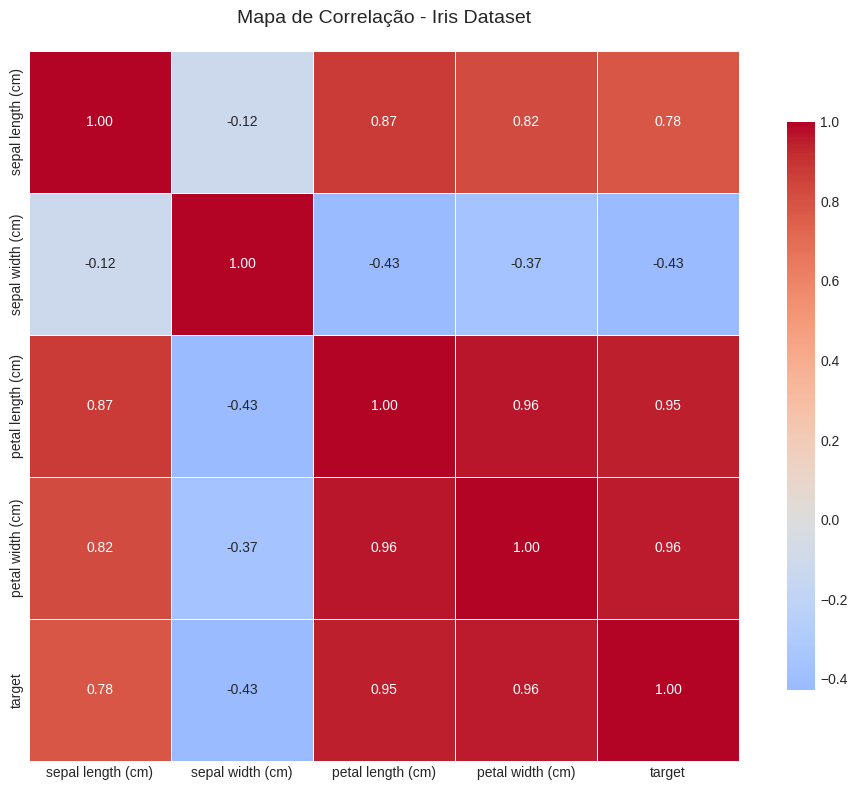


 Distribuição de características:


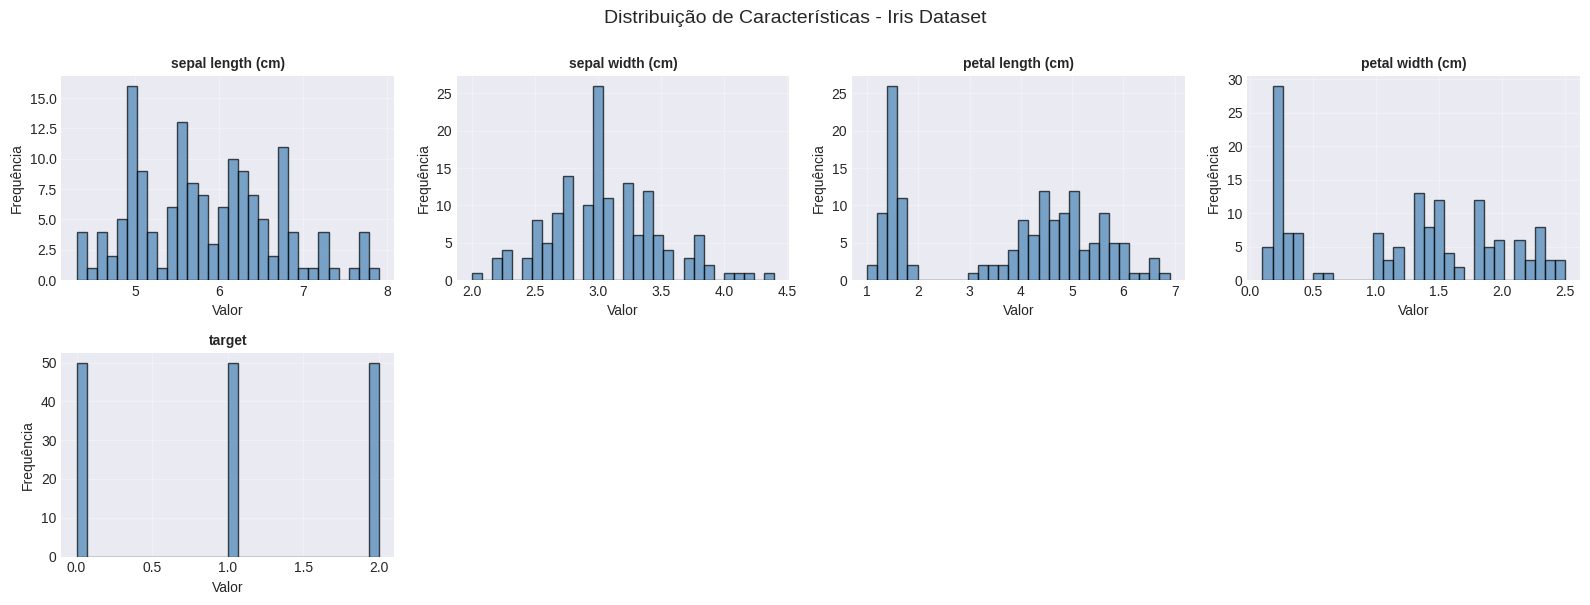

In [43]:
analisis_exploratorio(df_iris, "Iris Dataset")

# **CARREGAMENTO DO DATASET 2 - WINE**

In [45]:
print(" CARREGANDO DATASET 2: WINE")
print("="*100)

# Carregar dataset Wine
wine = sklearn.datasets.load_wine()
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine['target'] = wine.target
df_wine['target_name'] = [wine.target_names[i] for i in wine.target]

print(f"\n Informações do dataset:")
print(f"   - Características: {len(wine.feature_names)}")
print(f"   - Classes: {list(wine.target_names)}")
print(f"   - Total de amostras: {len(df_wine)}")
print(f"   - Amostras por classe:")
for i, name in enumerate(wine.target_names):
    count = np.sum(wine.target == i)
    print(f"     • {name}: {count}")

print(f"\n Pré-visualização do dataset:")
display(df_wine.head(10))


 CARREGANDO DATASET 2: WINE

 Informações do dataset:
   - Características: 13
   - Classes: [np.str_('class_0'), np.str_('class_1'), np.str_('class_2')]
   - Total de amostras: 178
   - Amostras por classe:
     • class_0: 59
     • class_1: 71
     • class_2: 48

 Pré-visualização do dataset:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,target_name
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0,class_0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0,class_0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,0,class_0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0,class_0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0,class_0


# **ANÁLISE EXPLORATÓRIA - WINE**

 ANÁLISE EXPLORATÓRIA: Wine Dataset

 Dimensões do dataset: 178 amostras × 15 características

 Primeiras linhas do dataset:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,target_name
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0



 Estatísticas descritivas:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000



 Mapa de Correlação:


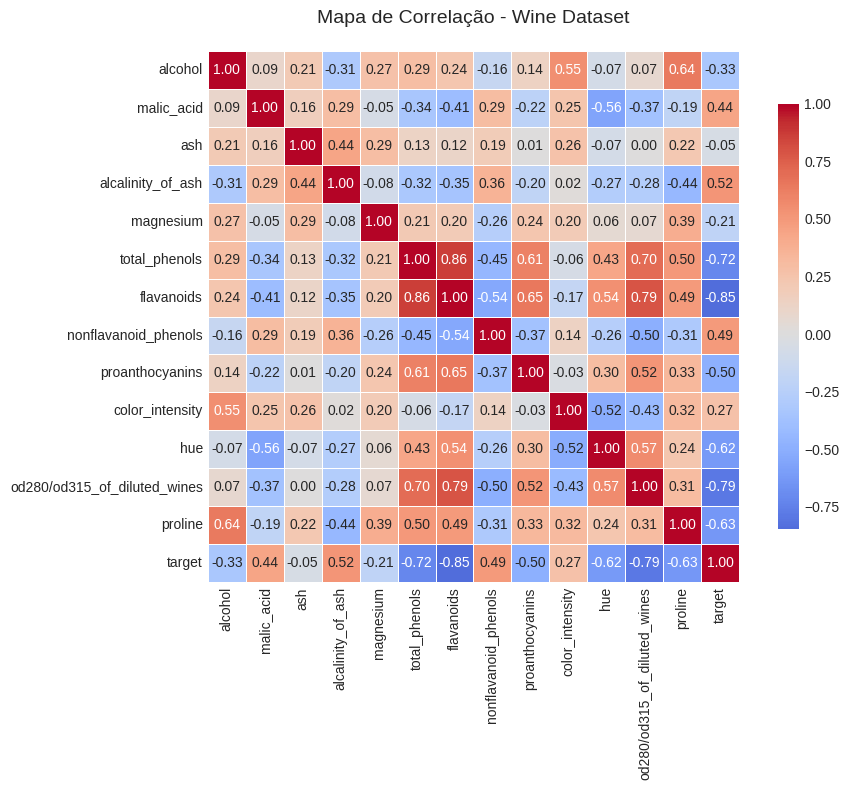


 Distribuição de características:


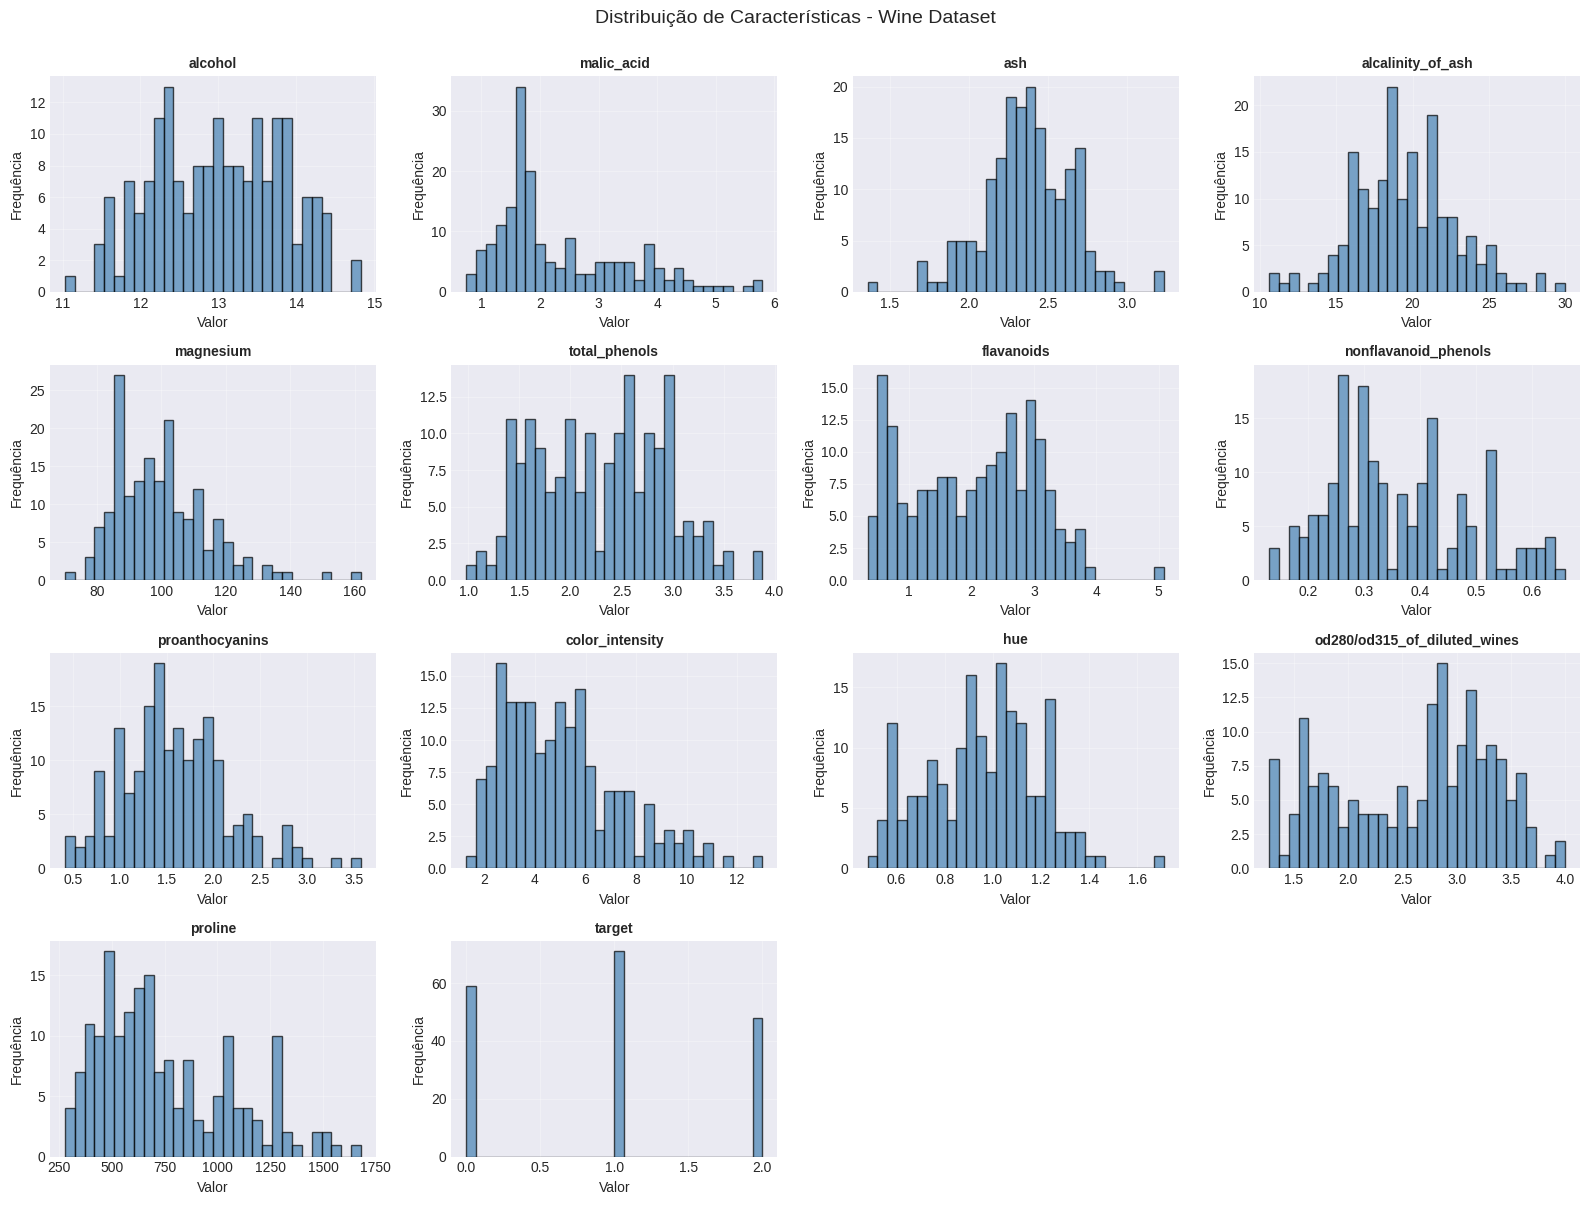

In [46]:
analisis_exploratorio(df_wine, "Wine Dataset")

# **PRÉ-PROCESSAMENTO E NORMALIZAÇÃO**

In [47]:
print(" PRÉ-PROCESSAMENTO E NORMALIZAÇÃO")
print("="*100)

print("\n IMPORTÂNCIA DA NORMALIZAÇÃO NO SOM:")
print("   As redes SOM são sensíveis à escala das características.")
print("   Se uma característica tiver valores muito maiores que outras,")
print("   dominará o treinamento. A normalização resolve isso.")
print("\n   Método utilizado: MinMaxScaler (intervalo [0, 1])")

# Preparar datasets
datasets = {
    'Iris': {
        'X': df_iris.drop(['target', 'target_name'], axis=1).values,
        'y': df_iris['target'].values,
        'feature_names': iris.feature_names,
        'class_names': iris.target_names
    },
    'Wine': {
        'X': df_wine.drop(['target', 'target_name'], axis=1).values,
        'y': df_wine['target'].values,
        'feature_names': wine.feature_names,
        'class_names': wine.target_names
    }
}

# Normalização
scaler = MinMaxScaler()

for name in datasets.keys():
    X_original = datasets[name]['X']
    X_norm = scaler.fit_transform(X_original)
    datasets[name]['X_norm'] = X_norm

    print(f"\n {name}:")
    print(f"   Antes: min={X_original.min():.2f}, max={X_original.max():.2f}")
    print(f"   Depois: min={X_norm.min():.2f}, max={X_norm.max():.2f}")


 PRÉ-PROCESSAMENTO E NORMALIZAÇÃO

 IMPORTÂNCIA DA NORMALIZAÇÃO NO SOM:
   As redes SOM são sensíveis à escala das características.
   Se uma característica tiver valores muito maiores que outras,
   dominará o treinamento. A normalização resolve isso.

   Método utilizado: MinMaxScaler (intervalo [0, 1])

 Iris:
   Antes: min=0.10, max=7.90
   Depois: min=0.00, max=1.00

 Wine:
   Antes: min=0.13, max=1680.00
   Depois: min=0.00, max=1.00


# **CONFIGURAÇÕES DE SOM A TESTAR**

**Parâmetros do SOM**

**1. GRID (tamanho do mapa)**
- **Grid pequeno (5x5):** Rápido, menos detalhe
- **Grid médio (7x7):** Equilíbrio entre detalhe e tempo
- **Grid grande (10x10):** Mais detalhe, mais tempo de treinamento

**2. SIGMA (raio de vizinhança inicial)**
- **Alto:** Aprendizado mais global no início
- **Baixo:** Aprendizado mais local desde o começo

**3. LEARNING RATE (taxa de aprendizado)**
- **Alto:** Mudanças rápidas, pode ser instável
- **Baixo:** Mudanças lentas, mais estável

**4. ITERAÇÕES**
- Mais iterações = melhor convergência (até certo ponto)


In [48]:
# Definir configurações
configuracoes = [
    {
        'grid': (5, 5),
        'sigma': 1.0,
        'lr': 0.5,
        'iter': 1000,
        'nome': 'Config 1: Rápida (5x5, sigma=1.0, lr=0.5)'
    },
    {
        'grid': (7, 7),
        'sigma': 1.5,
        'lr': 0.3,
        'iter': 1500,
        'nome': 'Config 2: Balanceada (7x7, sigma=1.5, lr=0.3)'
    },
    {
        'grid': (10, 10),
        'sigma': 2.0,
        'lr': 0.1,
        'iter': 2000,
        'nome': 'Config 3: Detalhada (10x10, sigma=2.0, lr=0.1)'
    },
]

print("\n Configurações definidas:")
for i, config in enumerate(configuracoes, 1):
    print(f"\n   Config {i}:")
    print(f"   - Grid: {config['grid'][0]}x{config['grid'][1]} ({config['grid'][0]*config['grid'][1]} neurônios)")
    print(f"   - Sigma: {config['sigma']}")
    print(f"   - Taxa de Aprendizado: {config['lr']}")
    print(f"   - Iterações: {config['iter']}")



 Configurações definidas:

   Config 1:
   - Grid: 5x5 (25 neurônios)
   - Sigma: 1.0
   - Taxa de Aprendizado: 0.5
   - Iterações: 1000

   Config 2:
   - Grid: 7x7 (49 neurônios)
   - Sigma: 1.5
   - Taxa de Aprendizado: 0.3
   - Iterações: 1500

   Config 3:
   - Grid: 10x10 (100 neurônios)
   - Sigma: 2.0
   - Taxa de Aprendizado: 0.1
   - Iterações: 2000


# **TREINAMENTO - IRIS CONFIG 1**

TREINAMENTO: IRIS - CONFIGURAÇÃO 1

 Treinando SOM com: Config 1: Rápida (5x5, sigma=1.0, lr=0.5)

MÉTRICAS DE QUALIDADE:
   • Silhouette Score: 0.2437 (próximo de 1 = melhor)
   • Davies-Bouldin Index: 1.0795 (menor = melhor)
   • Calinski-Harabasz Score: 158.44 (maior = melhor)
   • Quantization Error: 0.0940 (erro de quantização)
   • Topographic Error: 0.1533 (erro topográfico)
   • Outliers detectados: 6 (4.0%)

  U-Matrix:
   Mostra as distâncias entre neurônios vizinhos.
   Cores escuras = maior distância = fronteiras entre clusters


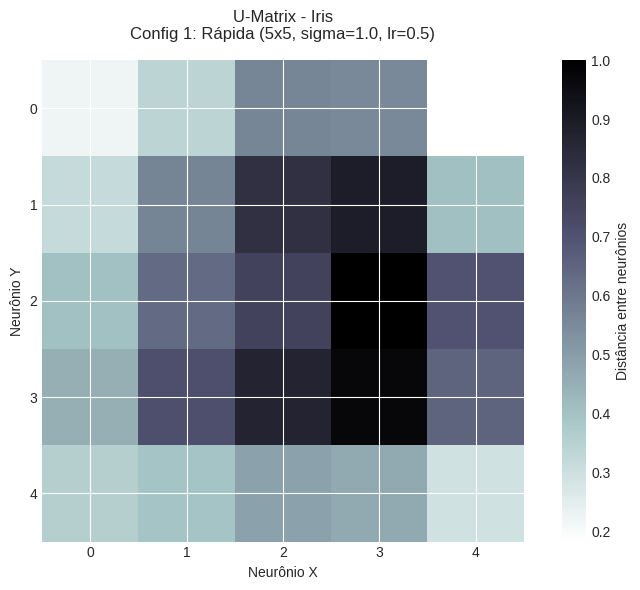


 Hit Map:
   Mostra quantas amostras são atribuídas a cada neurônio.
   Números maiores = neurônio mais representativo


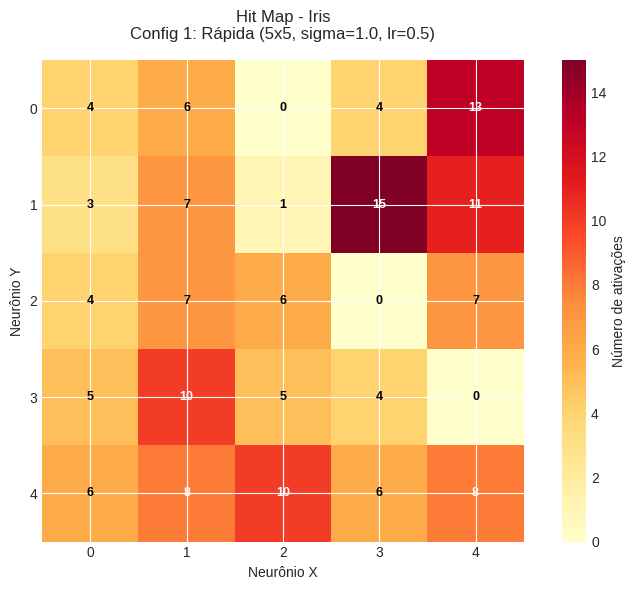


 Mapa de Distribuição de Classes:
   Cada cor representa uma classe diferente.
   A agrupação espacial indica semelhança entre amostras


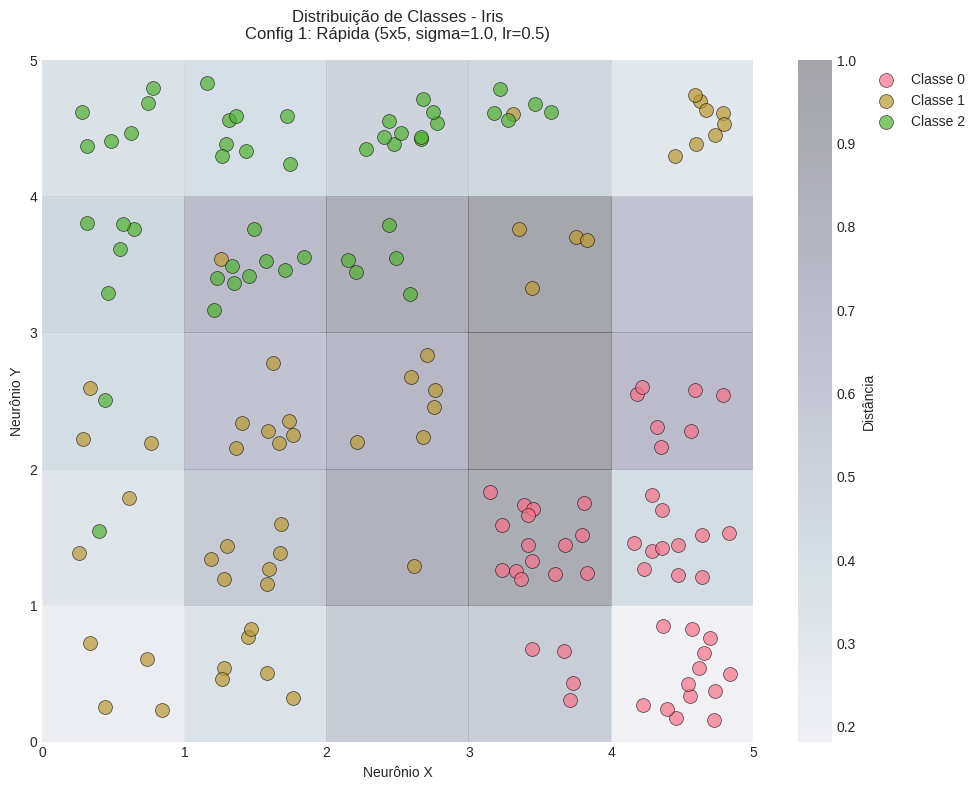

In [50]:
print("TREINAMENTO: IRIS - CONFIGURAÇÃO 1")
print("="*100)

dataset_name = 'Iris'
config = configuracoes[0]

X = datasets[dataset_name]['X_norm']
y = datasets[dataset_name]['y']
feature_names = datasets[dataset_name]['feature_names']

print(f"\n Treinando SOM com: {config['nome']}")

# Treinar SOM
som_iris_1 = entrenar_som(X,
                          grid_size=config['grid'],
                          sigma=config['sigma'],
                          learning_rate=config['lr'],
                          iterations=config['iter'])

# Obter clusters
winners = np.array([som_iris_1.winner(x) for x in X])
labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

# Calcular métricas
metrics = calcular_metricas_clustering(X, labels)
q_error = som_iris_1.quantization_error(X)
t_error = som_iris_1.topographic_error(X)

# Detectar outliers
outliers, distancias = detectar_outliers(som_iris_1, X, threshold=2.0)
n_outliers = np.sum(outliers)

print(f"\nMÉTRICAS DE QUALIDADE:")
print(f"   • Silhouette Score: {metrics['silhouette']:.4f} (próximo de 1 = melhor)")
print(f"   • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f} (menor = melhor)")
print(f"   • Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f} (maior = melhor)")
print(f"   • Quantization Error: {q_error:.4f} (erro de quantização)")
print(f"   • Topographic Error: {t_error:.4f} (erro topográfico)")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(X)*100:.1f}%)")

# Visualizar
visualizar_som(som_iris_1, X, y, dataset_name, config['nome'])


# **TREINAMENTO - IRIS CONFIG 2**

TREINAMENTO: IRIS - CONFIGURAÇÃO 2

 Treinando SOM com: Config 2: Balanceada (7x7, sigma=1.5, lr=0.3)

 MÉTRICAS DE QUALIDADE:
   • Silhouette Score: 0.2295
   • Davies-Bouldin Index: 0.9344
   • Calinski-Harabasz Score: 146.31
   • Quantization Error: 0.0765
   • Topographic Error: 0.0600
   • Outliers detectados: 7 (4.7%)

  U-Matrix:
   Mostra as distâncias entre neurônios vizinhos.
   Cores escuras = maior distância = fronteiras entre clusters


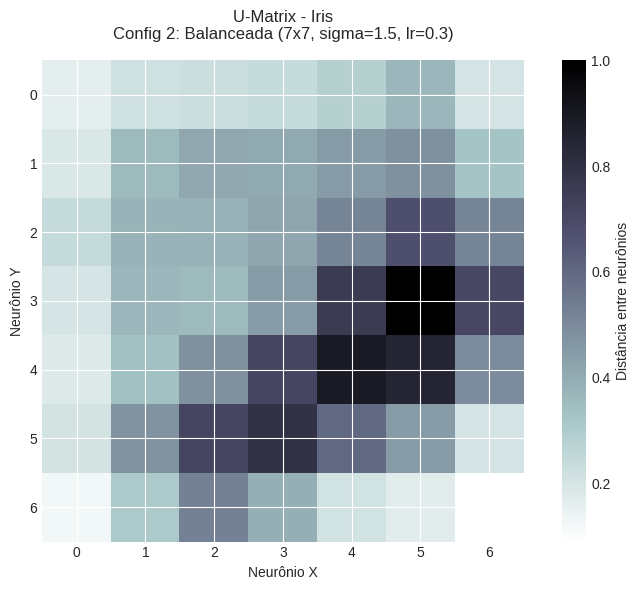


 Hit Map:
   Mostra quantas amostras são atribuídas a cada neurônio.
   Números maiores = neurônio mais representativo


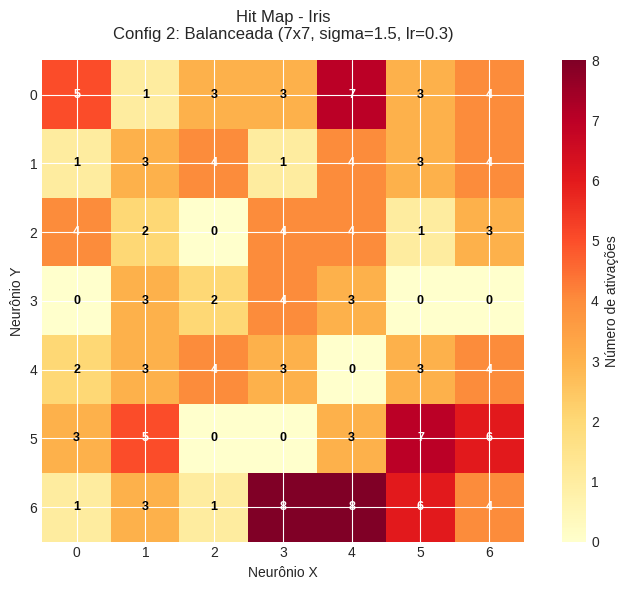


 Mapa de Distribuição de Classes:
   Cada cor representa uma classe diferente.
   A agrupação espacial indica semelhança entre amostras


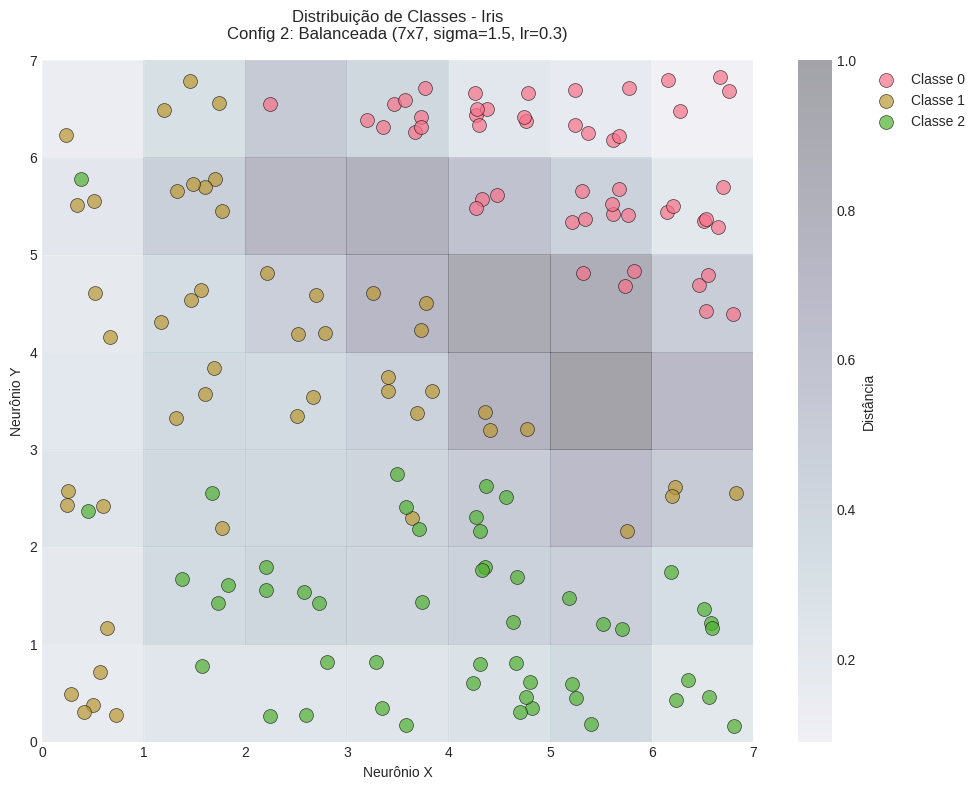

In [51]:
print("TREINAMENTO: IRIS - CONFIGURAÇÃO 2")
print("="*100)

config = configuracoes[1]

print(f"\n Treinando SOM com: {config['nome']}")

som_iris_2 = entrenar_som(X,
                          grid_size=config['grid'],
                          sigma=config['sigma'],
                          learning_rate=config['lr'],
                          iterations=config['iter'])

winners = np.array([som_iris_2.winner(x) for x in X])
labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

metrics = calcular_metricas_clustering(X, labels)
q_error = som_iris_2.quantization_error(X)
t_error = som_iris_2.topographic_error(X)
outliers, distancias = detectar_outliers(som_iris_2, X, threshold=2.0)
n_outliers = np.sum(outliers)

print(f"\n MÉTRICAS DE QUALIDADE:")
print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
print(f"   • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
print(f"   • Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f}")
print(f"   • Quantization Error: {q_error:.4f}")
print(f"   • Topographic Error: {t_error:.4f}")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(X)*100:.1f}%)")

visualizar_som(som_iris_2, X, y, dataset_name, config['nome'])


# **ENTRENAMIENTO - IRIS CONFIG 3**

TREINAMENTO: IRIS - CONFIGURAÇÃO 3

 Treinando SOM com: Config 3: Detalhada (10x10, sigma=2.0, lr=0.1)

 MÉTRICAS DE QUALIDADE:
   • Silhouette Score: 0.0775
   • Davies-Bouldin Index: 0.8772
   • Calinski-Harabasz Score: 97.44
   • Quantization Error: 0.0760
   • Topographic Error: 0.0333
   • Outliers detectados: 8 (5.3%)

  U-Matrix:
   Mostra as distâncias entre neurônios vizinhos.
   Cores escuras = maior distância = fronteiras entre clusters


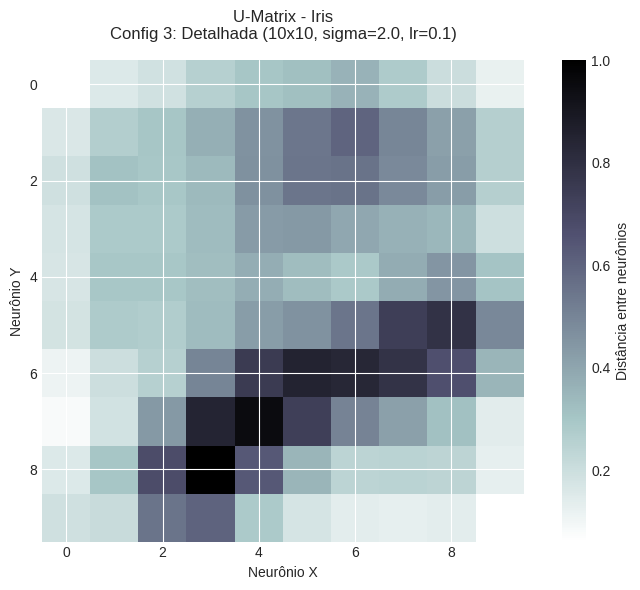


 Hit Map:
   Mostra quantas amostras são atribuídas a cada neurônio.
   Números maiores = neurônio mais representativo


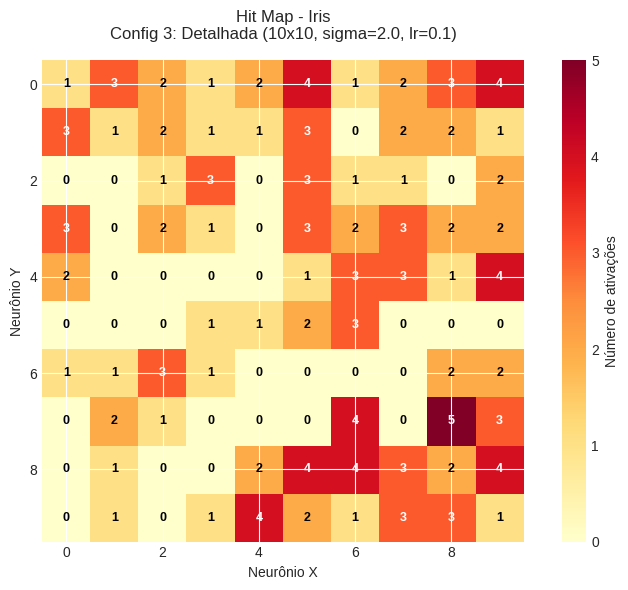


 Mapa de Distribuição de Classes:
   Cada cor representa uma classe diferente.
   A agrupação espacial indica semelhança entre amostras


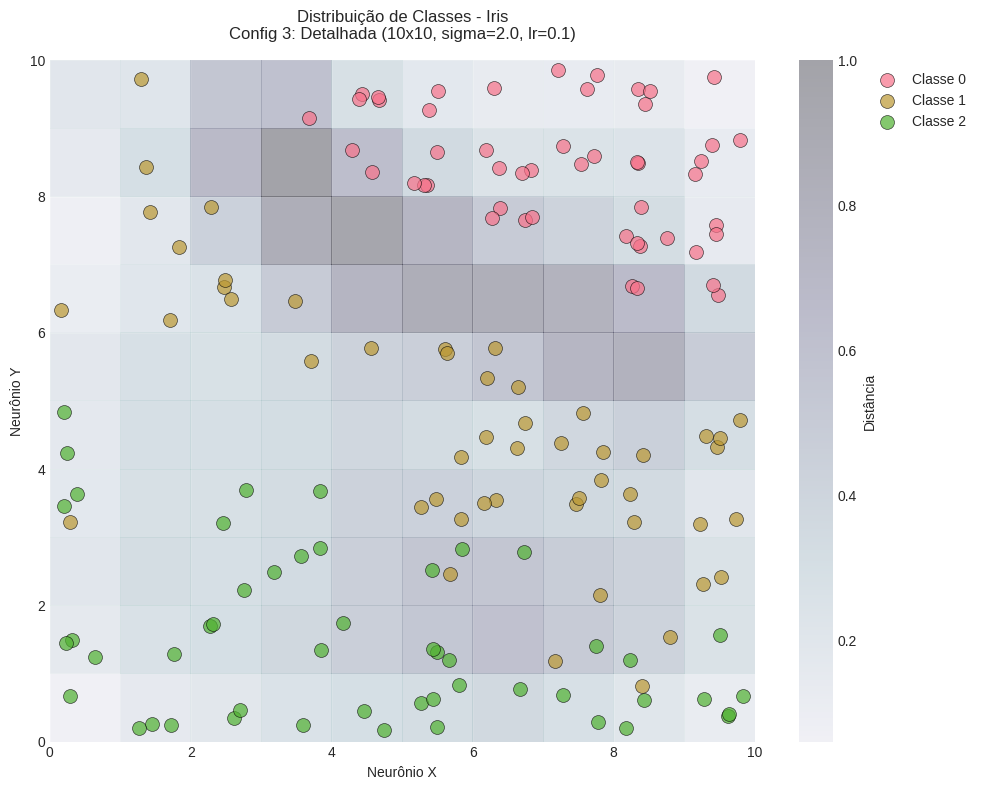

In [52]:
print("TREINAMENTO: IRIS - CONFIGURAÇÃO 3")
print("="*100)

config = configuracoes[2]

print(f"\n Treinando SOM com: {config['nome']}")

som_iris_3 = entrenar_som(X,
                          grid_size=config['grid'],
                          sigma=config['sigma'],
                          learning_rate=config['lr'],
                          iterations=config['iter'])

winners = np.array([som_iris_3.winner(x) for x in X])
labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

metrics = calcular_metricas_clustering(X, labels)
q_error = som_iris_3.quantization_error(X)
t_error = som_iris_3.topographic_error(X)
outliers, distancias = detectar_outliers(som_iris_3, X, threshold=2.0)
n_outliers = np.sum(outliers)

print(f"\n MÉTRICAS DE QUALIDADE:")
print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
print(f"   • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
print(f"   • Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f}")
print(f"   • Quantization Error: {q_error:.4f}")
print(f"   • Topographic Error: {t_error:.4f}")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(X)*100:.1f}%)")

visualizar_som(som_iris_3, X, y, dataset_name, config['nome'])


# **PLANOS DE COMPONENTES - IRIS**

**Usaremos a Config 2 (balanceada) para a análise detalhada.**

**Interpretação:**
- Buscar padrões semelhantes entre diferentes planos de componentes.
- Regiões com cores semelhantes em múltiplos planos sugerem que essas características co-variam.


PLANOS DE COMPONENTES - IRIS

 Component Planes:
   Cada mapa mostra a influência de uma característica no SOM.
   Regiões com cores semelhantes = valores semelhantes dessa característica


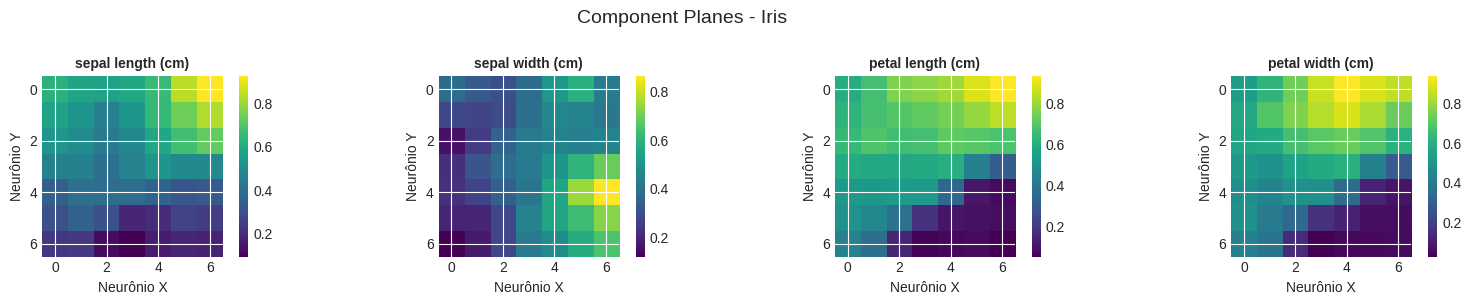

In [55]:
print("PLANOS DE COMPONENTES - IRIS")
print("="*100)

visualizar_component_planes(som_iris_2, X, feature_names, dataset_name)



VISUALIZAÇÃO COMPARATIVA - IRIS


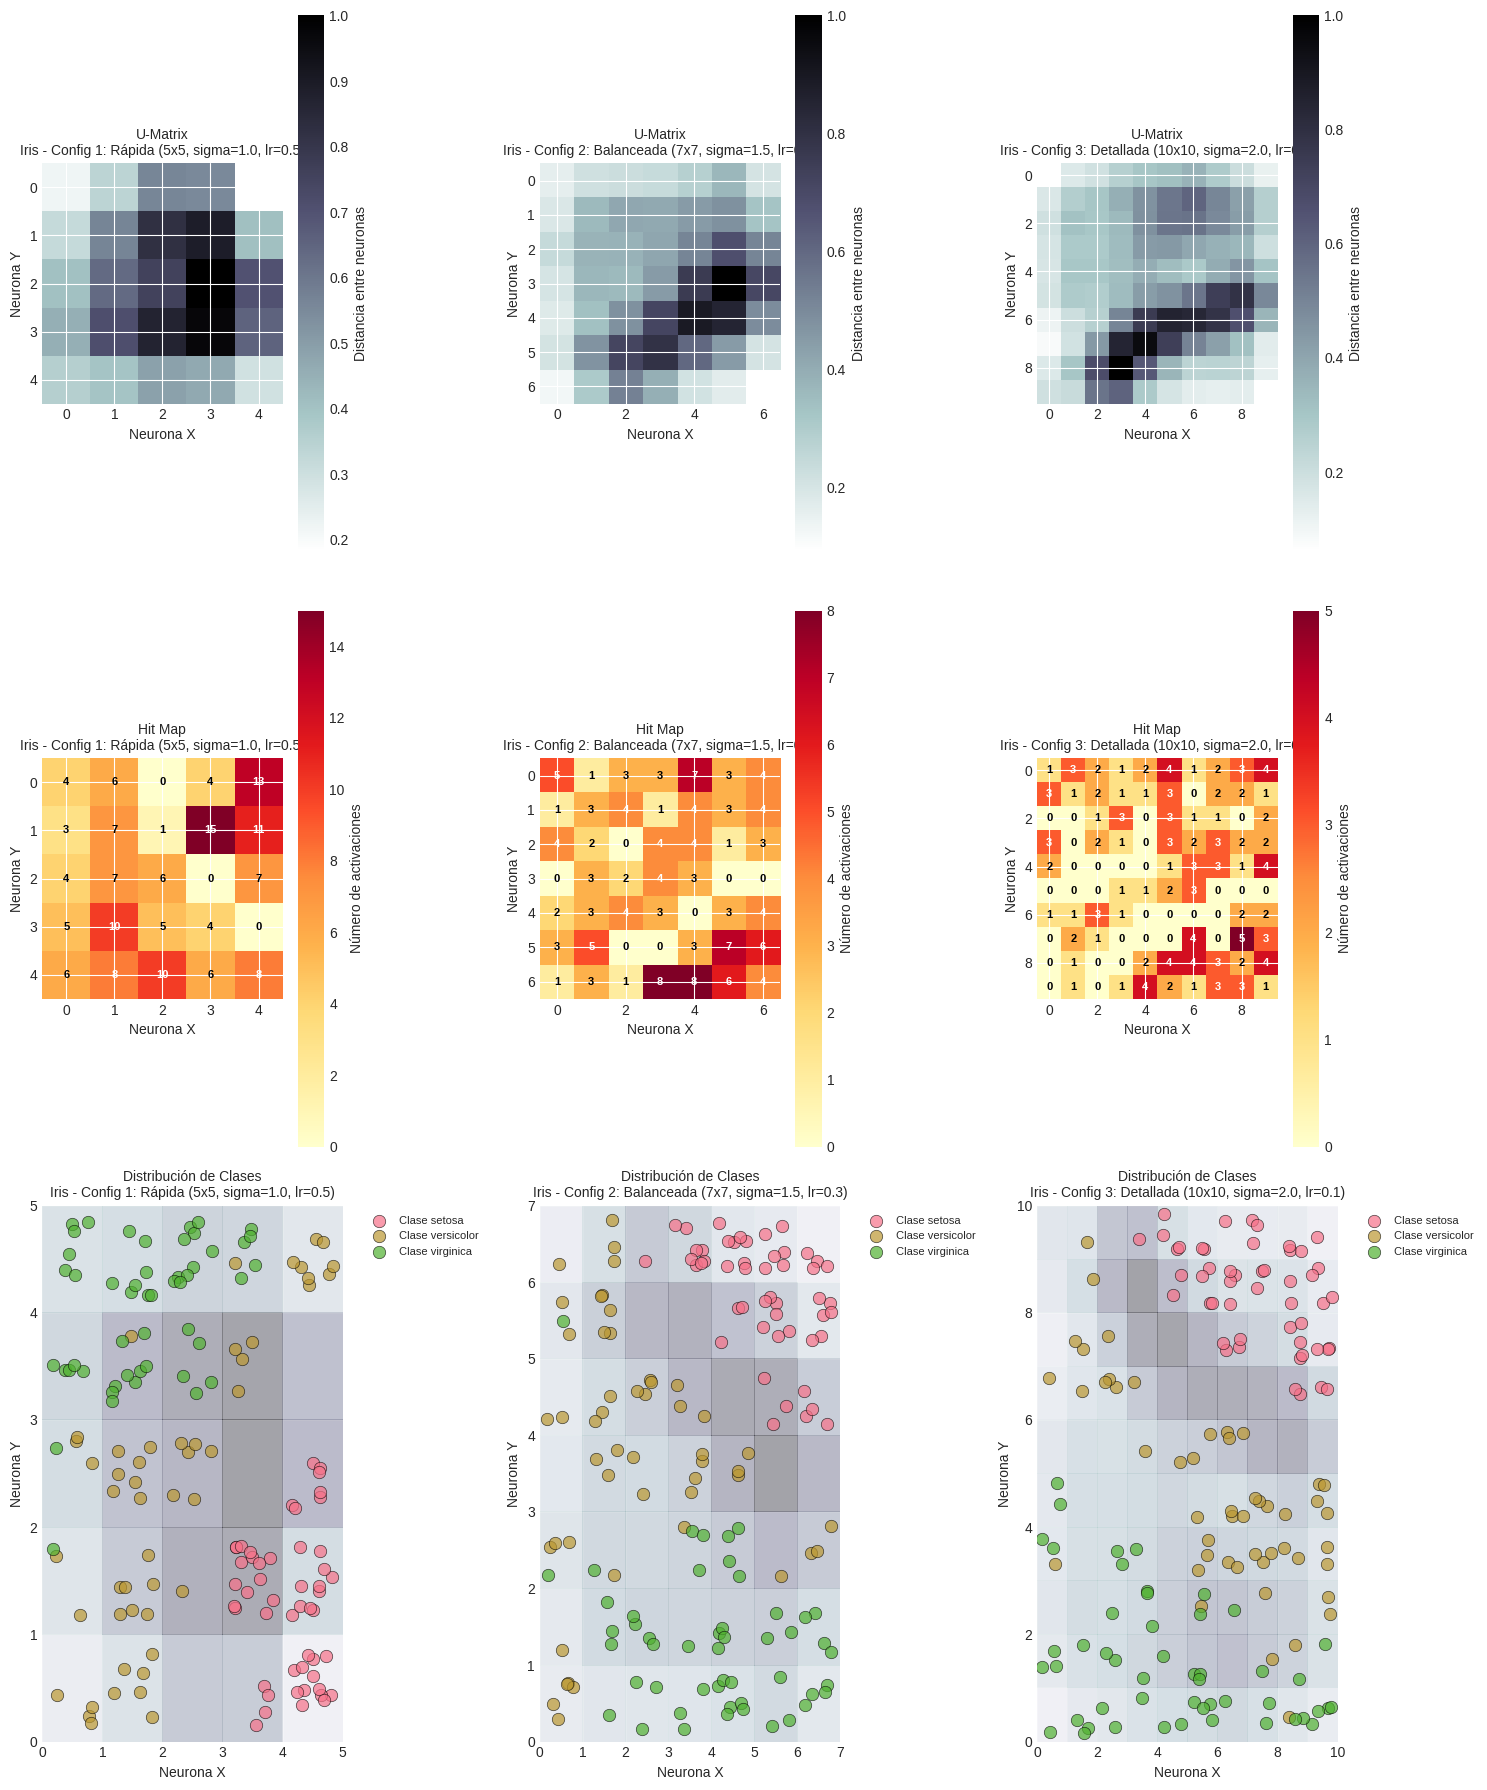

In [80]:
print("VISUALIZAÇÃO COMPARATIVA - IRIS")
print("="*100)

# Coletar os SOMs e informações para o conjunto de dados Iris
iris_soms = [som_iris_1, som_iris_2, som_iris_3]
iris_datasets_info = {'Iris': datasets['Iris']}
iris_config_names = [config['nombre'] for config in configuraciones]
iris_dataset_names = ['Iris']

# Visualizar os SOMs do Iris lado a lado
visualizar_comparacion_som(iris_soms, iris_datasets_info, iris_config_names, iris_dataset_names)

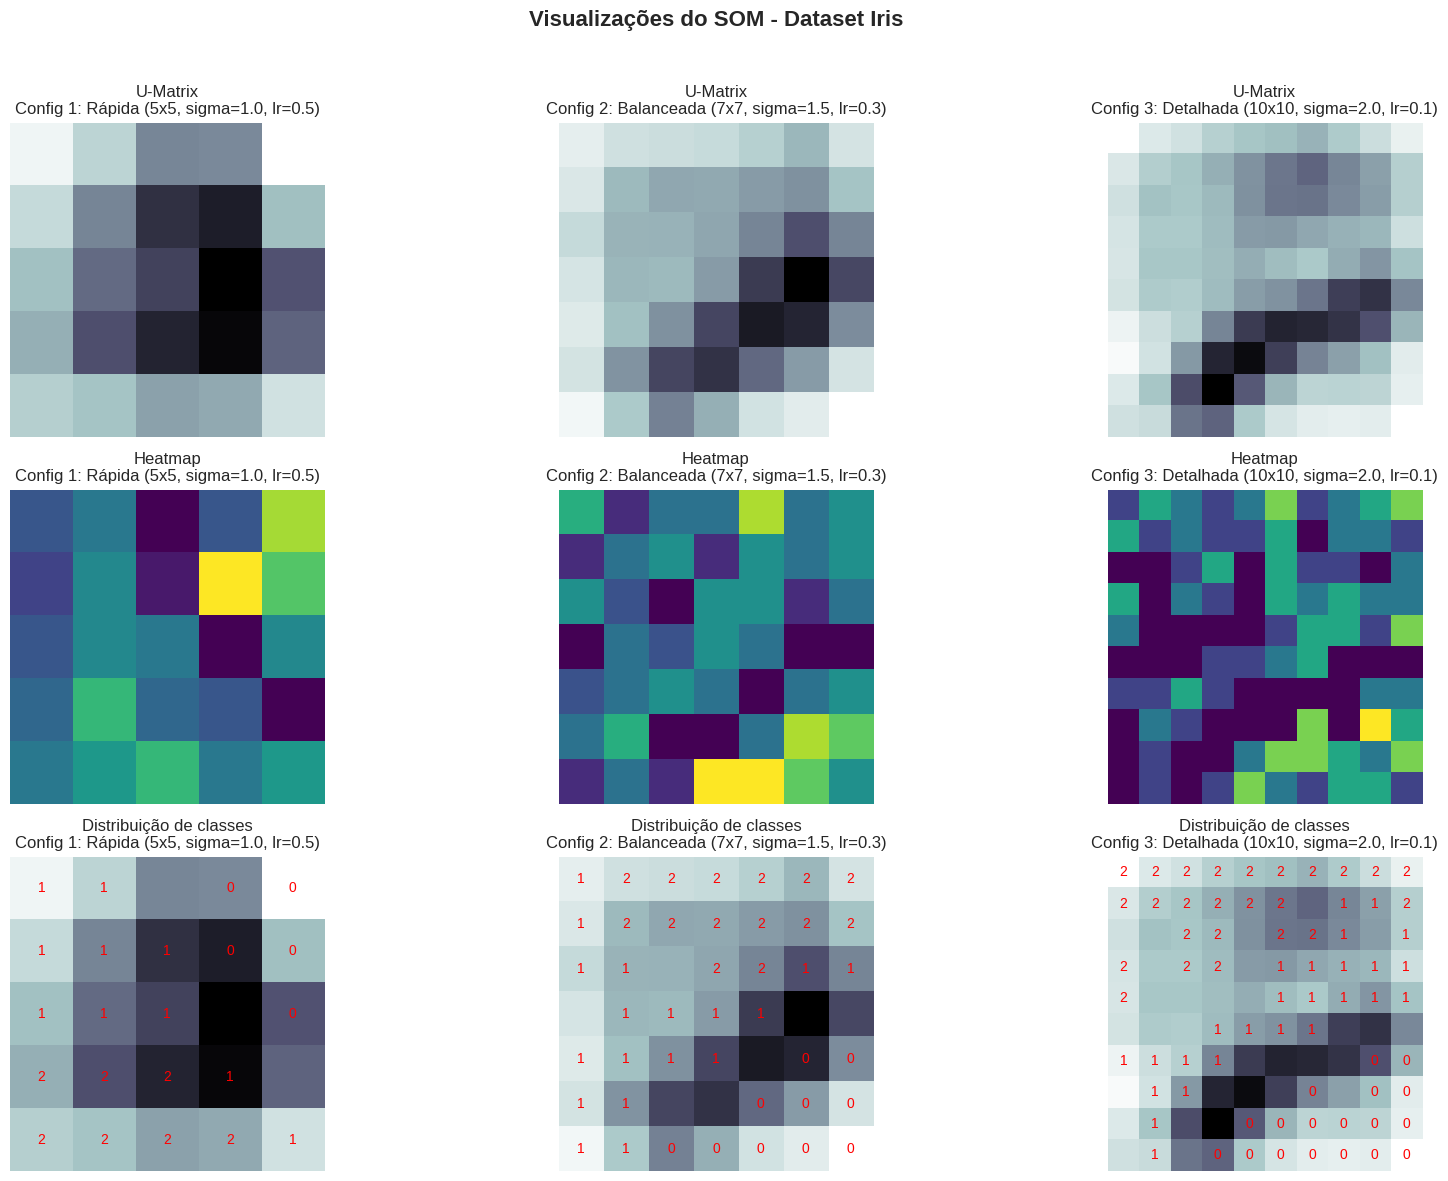

In [56]:
import matplotlib.pyplot as plt

# Criar figura geral com 3 colunas (configurações) e 3 linhas (tipos de visualização)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Visualizações do SOM - Dataset Iris", fontsize=16, fontweight='bold')

# Lista de configurações e SOMs
soms = [som_iris_1, som_iris_2, som_iris_3]
config_names = [configuracoes[0]['nome'], configuracoes[1]['nome'], configuracoes[2]['nome']]
visual_types = ['U-Matrix', 'Heatmap', 'Distribuição de classes']

# Funções internas (ajuste conforme suas funções reais)
def plot_umatrix(som, ax, title):
    u_matrix = som.distance_map().T
    ax.imshow(u_matrix, cmap='bone_r')
    ax.set_title(title)
    ax.axis('off')

def plot_heatmap(som, ax, title):
    ax.imshow(som.activation_response(datasets['Iris']['X_norm']).T, cmap='viridis')
    ax.set_title(title)
    ax.axis('off')

def plot_class_distribution(som, X, y, ax, title):
    from minisom import MiniSom
    labels_map = som.labels_map(X, y)
    ax.imshow(som.distance_map().T, cmap='bone_r')
    for coord, label_dict in labels_map.items():
        ax.text(coord[0], coord[1], max(label_dict, key=label_dict.get), ha='center', va='center', color='red')
    ax.set_title(title)
    ax.axis('off')

# Gerar os gráficos
for j, (som, conf_name) in enumerate(zip(soms, config_names)):
    plot_umatrix(som, axes[0, j], f'U-Matrix\n{conf_name}')
    plot_heatmap(som, axes[1, j], f'Heatmap\n{conf_name}')
    plot_class_distribution(som, datasets['Iris']['X_norm'], datasets['Iris']['y'], axes[2, j], f'Distribuição de classes\n{conf_name}')

# Etiquetas das linhas
for i, label in enumerate(visual_types):
    axes[i, 0].set_ylabel(label, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# **TREINAMENTO: WINE - CONFIGURAÇÃO 1**


 Treinando SOM com: Config 1: Rápida (5x5, sigma=1.0, lr=0.5)

MÉTRICAS DE QUALIDADE:
   • Silhouette Score: 0.1411
   • Davies-Bouldin Index: 1.4029
   • Calinski-Harabasz Score: 23.01
   • Quantization Error: 0.3512
   • Topographic Error: 0.1798
   • Outliers detectados: 6 (3.4%)

  U-Matrix:
   Mostra as distâncias entre neurônios vizinhos.
   Cores escuras = maior distância = fronteiras entre clusters


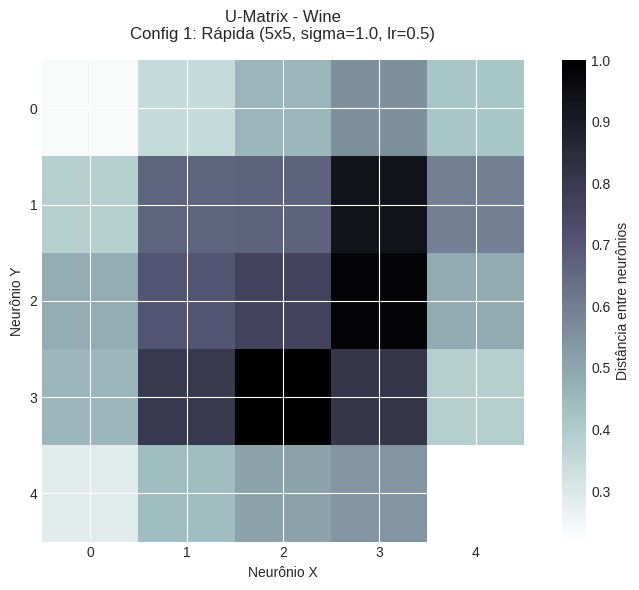


 Hit Map:
   Mostra quantas amostras são atribuídas a cada neurônio.
   Números maiores = neurônio mais representativo


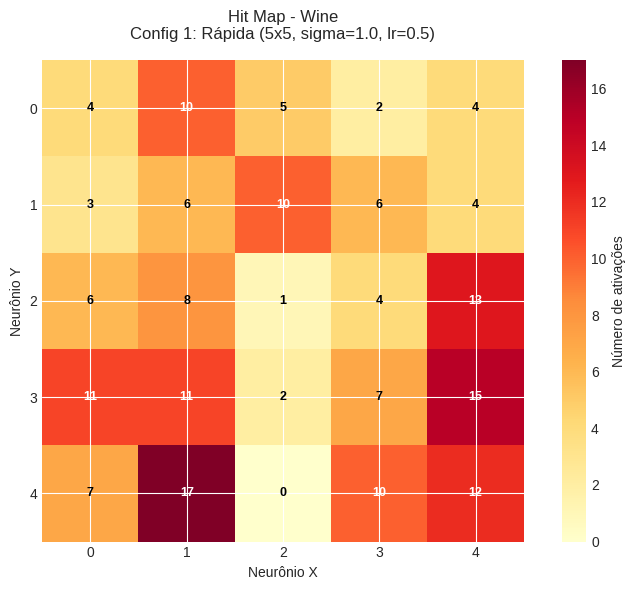


 Mapa de Distribuição de Classes:
   Cada cor representa uma classe diferente.
   A agrupação espacial indica semelhança entre amostras


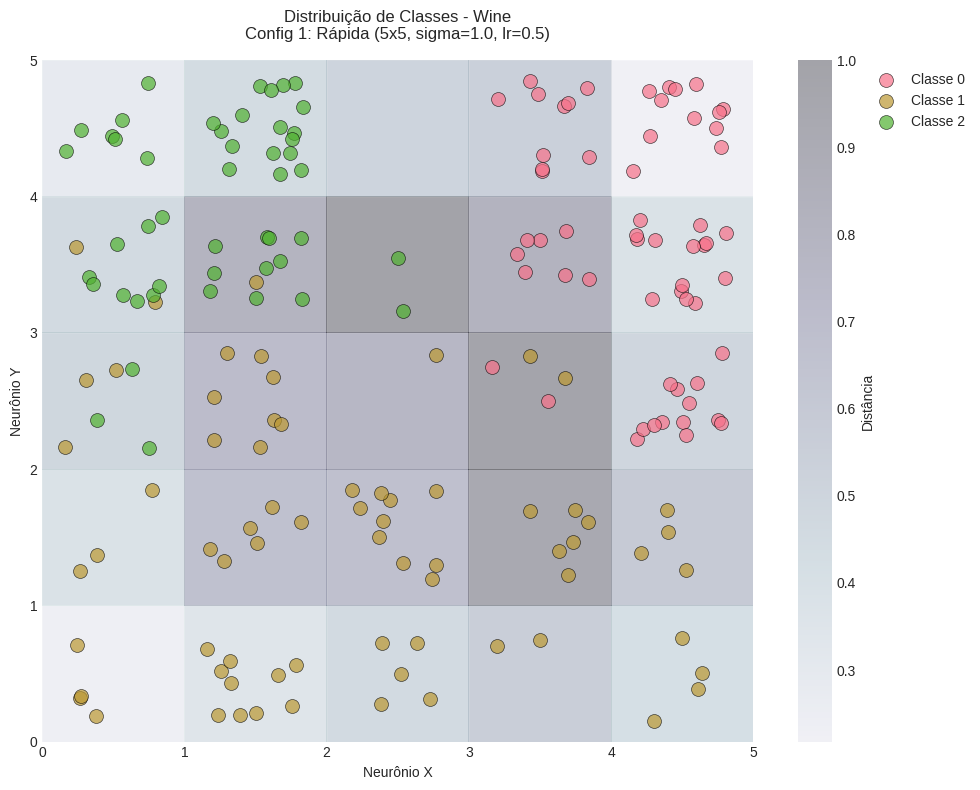

In [57]:
dataset_name = 'Wine'
config = configuracoes[0]

X = datasets[dataset_name]['X_norm']
y = datasets[dataset_name]['y']
feature_names = datasets[dataset_name]['feature_names']

print(f"\n Treinando SOM com: {config['nome']}")

som_wine_1 = entrenar_som(X,
                          grid_size=config['grid'],
                          sigma=config['sigma'],
                          learning_rate=config['lr'],
                          iterations=config['iter'])

winners = np.array([som_wine_1.winner(x) for x in X])
labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

metrics = calcular_metricas_clustering(X, labels)
q_error = som_wine_1.quantization_error(X)
t_error = som_wine_1.topographic_error(X)
outliers, distancias = detectar_outliers(som_wine_1, X, threshold=2.0)
n_outliers = np.sum(outliers)

print(f"\nMÉTRICAS DE QUALIDADE:")
print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
print(f"   • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
print(f"   • Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f}")
print(f"   • Quantization Error: {q_error:.4f}")
print(f"   • Topographic Error: {t_error:.4f}")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(X)*100:.1f}%)")

visualizar_som(som_wine_1, X, y, dataset_name, config['nome'])


# **TREINAMENTO - WINE CONFIG 2**

TREINAMENTO: WINE - CONFIGURAÇÃO 2

  Treinando SOM com: Config 2: Balanceada (7x7, sigma=1.5, lr=0.3)

MÉTRICAS DE QUALIDADE:
   • Silhouette Score: 0.0722
   • Davies-Bouldin Index: 1.4043
   • Calinski-Harabasz Score: 14.28
   • Quantization Error: 0.3222
   • Topographic Error: 0.0730
   • Outliers detectados: 7 (3.9%)

  U-Matrix:
   Mostra as distâncias entre neurônios vizinhos.
   Cores escuras = maior distância = fronteiras entre clusters


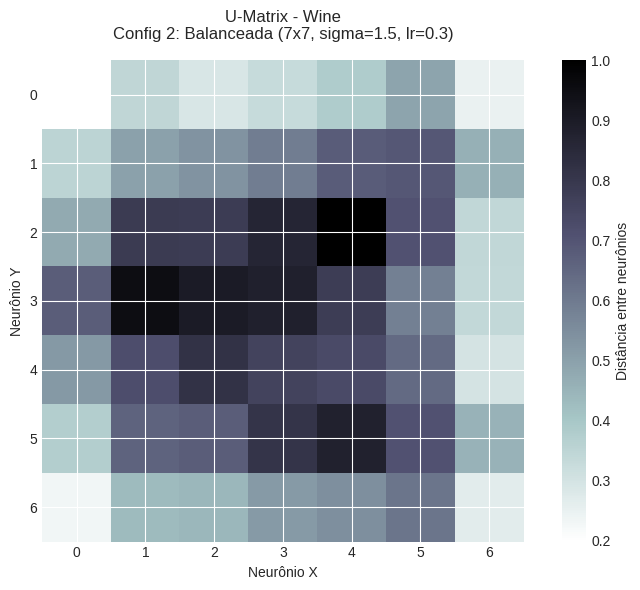


 Hit Map:
   Mostra quantas amostras são atribuídas a cada neurônio.
   Números maiores = neurônio mais representativo


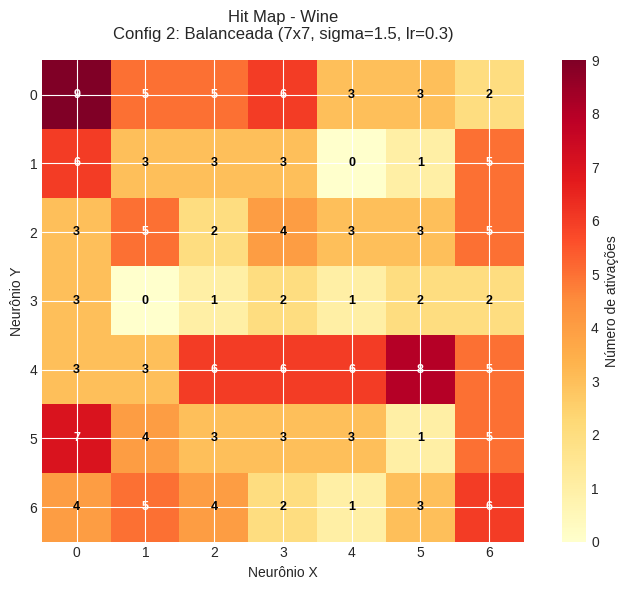


 Mapa de Distribuição de Classes:
   Cada cor representa uma classe diferente.
   A agrupação espacial indica semelhança entre amostras


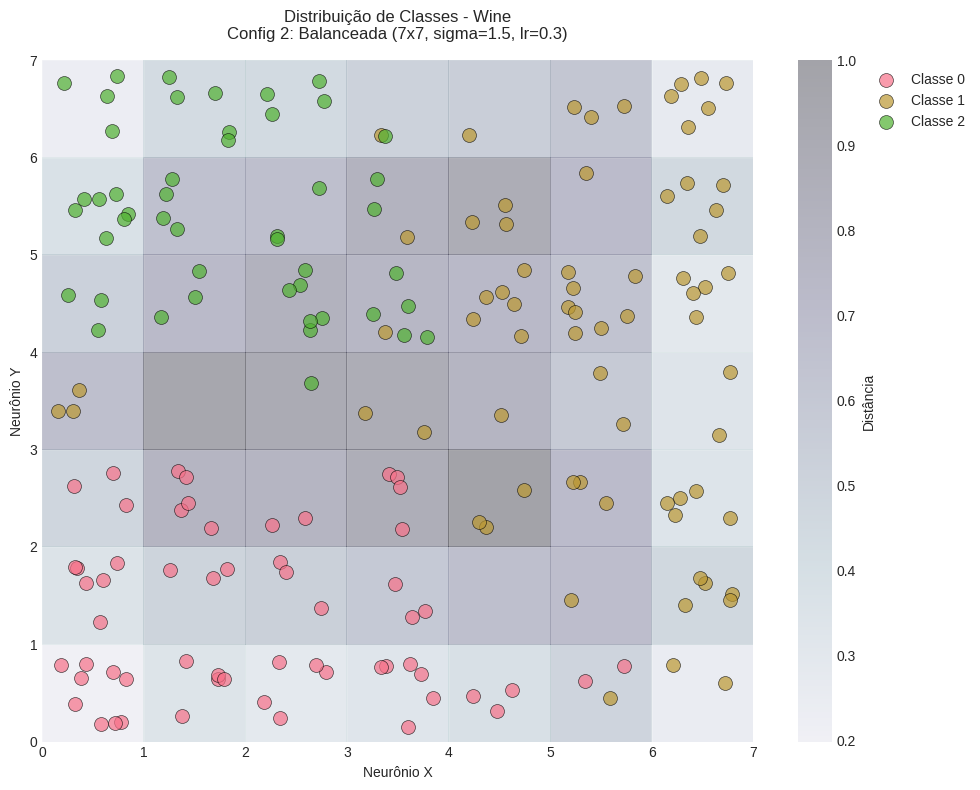

In [58]:
print("TREINAMENTO: WINE - CONFIGURAÇÃO 2")
print("="*100)

config = configuracoes[1]
print(f"\n  Treinando SOM com: {config['nome']}")

som_wine_2 = entrenar_som(X,
                          grid_size=config['grid'],
                          sigma=config['sigma'],
                          learning_rate=config['lr'],
                          iterations=config['iter'])

winners = np.array([som_wine_2.winner(x) for x in X])
labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

metrics = calcular_metricas_clustering(X, labels)
q_error = som_wine_2.quantization_error(X)
t_error = som_wine_2.topographic_error(X)
outliers, distancias = detectar_outliers(som_wine_2, X, threshold=2.0)
n_outliers = np.sum(outliers)

print(f"\nMÉTRICAS DE QUALIDADE:")
print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
print(f"   • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
print(f"   • Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f}")
print(f"   • Quantization Error: {q_error:.4f}")
print(f"   • Topographic Error: {t_error:.4f}")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(X)*100:.1f}%)")

visualizar_som(som_wine_2, X, y, dataset_name, config['nome'])


# **TREINAMENTO - WINE CONFIG 3**

TREINAMENTO: WINE - CONFIGURAÇÃO 3

  Treinando SOM com: Config 3: Detalhada (10x10, sigma=2.0, lr=0.1)

MÉTRICAS DE QUALIDADE:
   • Silhouette Score: 0.0212
   • Davies-Bouldin Index: 1.0996
   • Calinski-Harabasz Score: 10.99
   • Quantization Error: 0.3221
   • Topographic Error: 0.0169
   • Outliers detectados: 6 (3.4%)

  U-Matrix:
   Mostra as distâncias entre neurônios vizinhos.
   Cores escuras = maior distância = fronteiras entre clusters


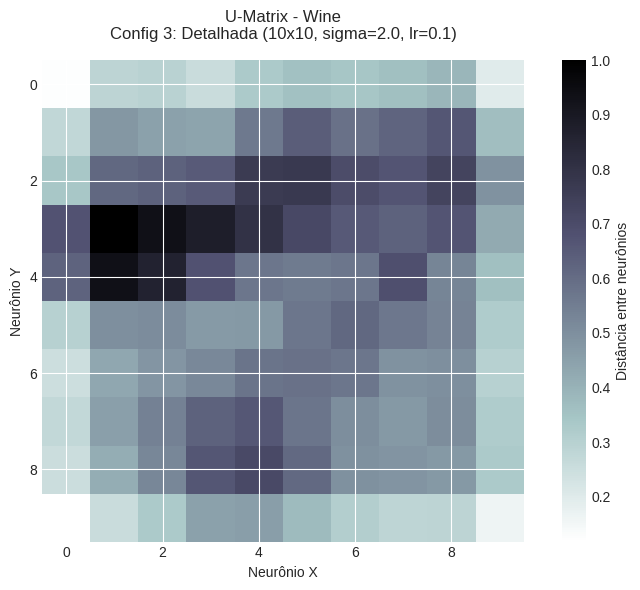


 Hit Map:
   Mostra quantas amostras são atribuídas a cada neurônio.
   Números maiores = neurônio mais representativo


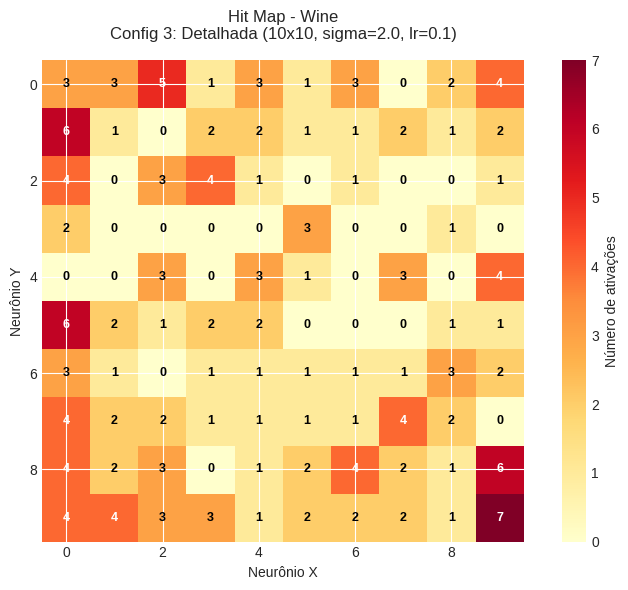


 Mapa de Distribuição de Classes:
   Cada cor representa uma classe diferente.
   A agrupação espacial indica semelhança entre amostras


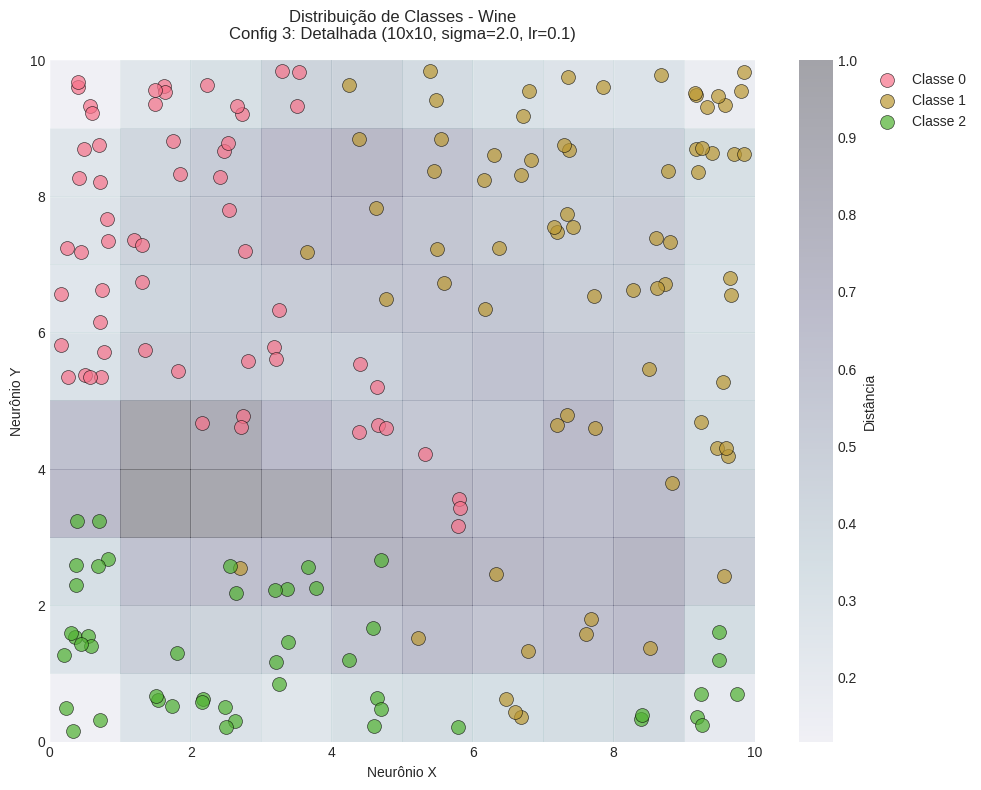

In [59]:
print("TREINAMENTO: WINE - CONFIGURAÇÃO 3")
print("="*100)

config = configuracoes[2]

print(f"\n  Treinando SOM com: {config['nome']}")

som_wine_3 = entrenar_som(X,
                          grid_size=config['grid'],
                          sigma=config['sigma'],
                          learning_rate=config['lr'],
                          iterations=config['iter'])

winners = np.array([som_wine_3.winner(x) for x in X])
labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

metrics = calcular_metricas_clustering(X, labels)
q_error = som_wine_3.quantization_error(X)
t_error = som_wine_3.topographic_error(X)
outliers, distancias = detectar_outliers(som_wine_3, X, threshold=2.0)
n_outliers = np.sum(outliers)

print(f"\nMÉTRICAS DE QUALIDADE:")
print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
print(f"   • Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
print(f"   • Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f}")
print(f"   • Quantization Error: {q_error:.4f}")
print(f"   • Topographic Error: {t_error:.4f}")
print(f"   • Outliers detectados: {n_outliers} ({n_outliers/len(X)*100:.1f}%)")

visualizar_som(som_wine_3, X, y, dataset_name, config['nome'])


VISUALIZAÇÃO COMPARATIVA - Wine


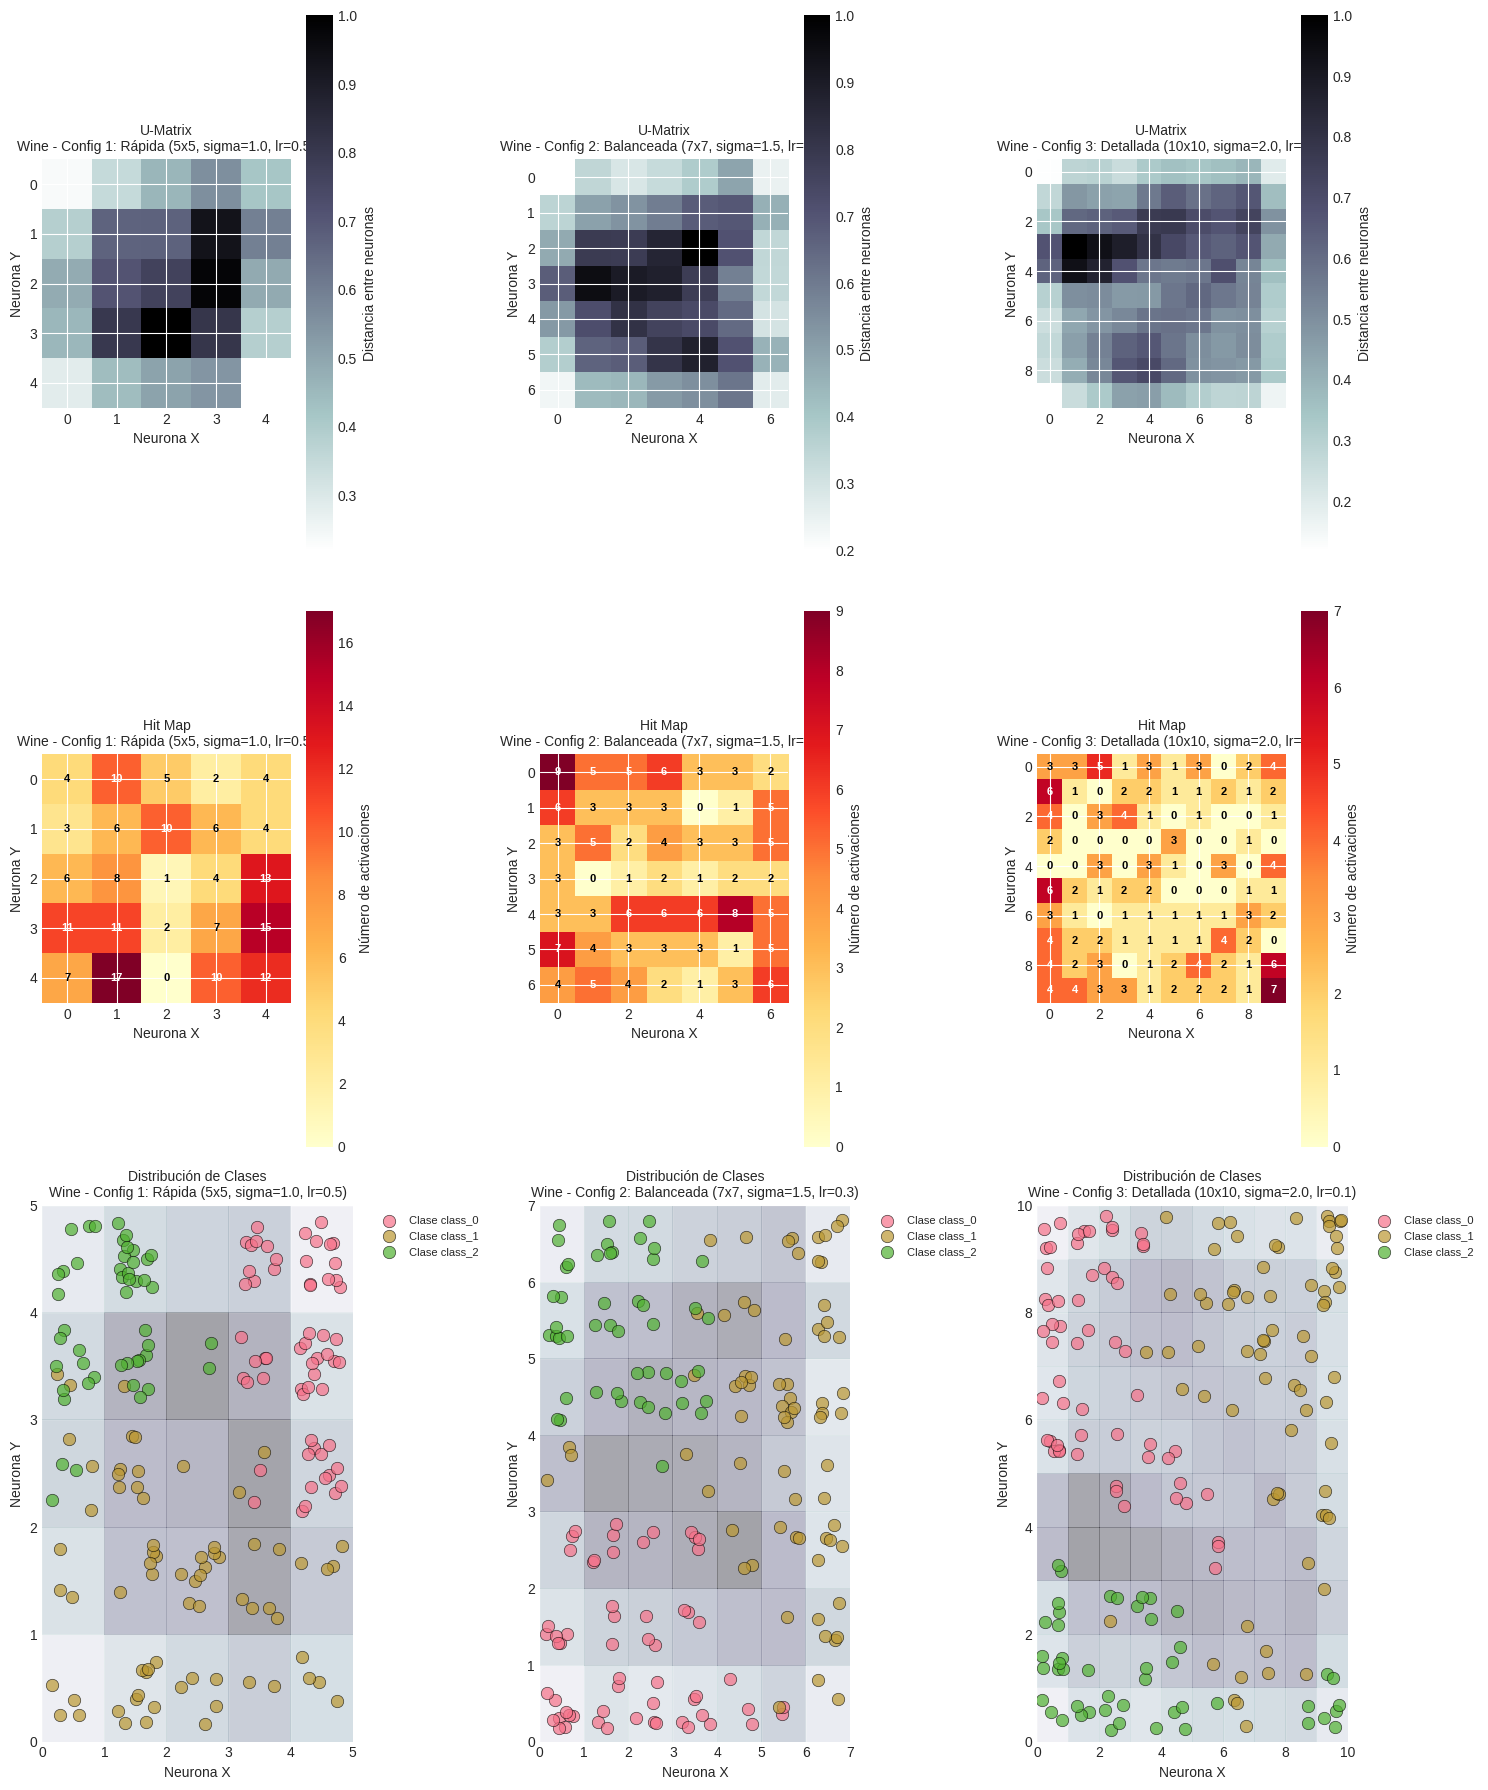

In [82]:
print("VISUALIZAÇÃO COMPARATIVA - Wine")
print("="*100)

# Coletar os SOMs e informações para o conjunto de dados Iris
iris_soms = [som_wine_1, som_wine_2, som_wine_3]
iris_datasets_info = {'Wine': datasets['Wine']}
iris_config_names = [config['nombre'] for config in configuraciones]
iris_dataset_names = ['Wine']

# Visualizar os SOMs do Iris lado a lado
visualizar_comparacion_som(iris_soms, iris_datasets_info, iris_config_names, iris_dataset_names)

# **PLANOS DE COMPONENTES - WINE**

**Usaremos a Configuração 2 (balanceada) para a análise detalhada**

PLANOS DE COMPONENTES - WINE

 Component Planes:
   Cada mapa mostra a influência de uma característica no SOM.
   Regiões com cores semelhantes = valores semelhantes dessa característica


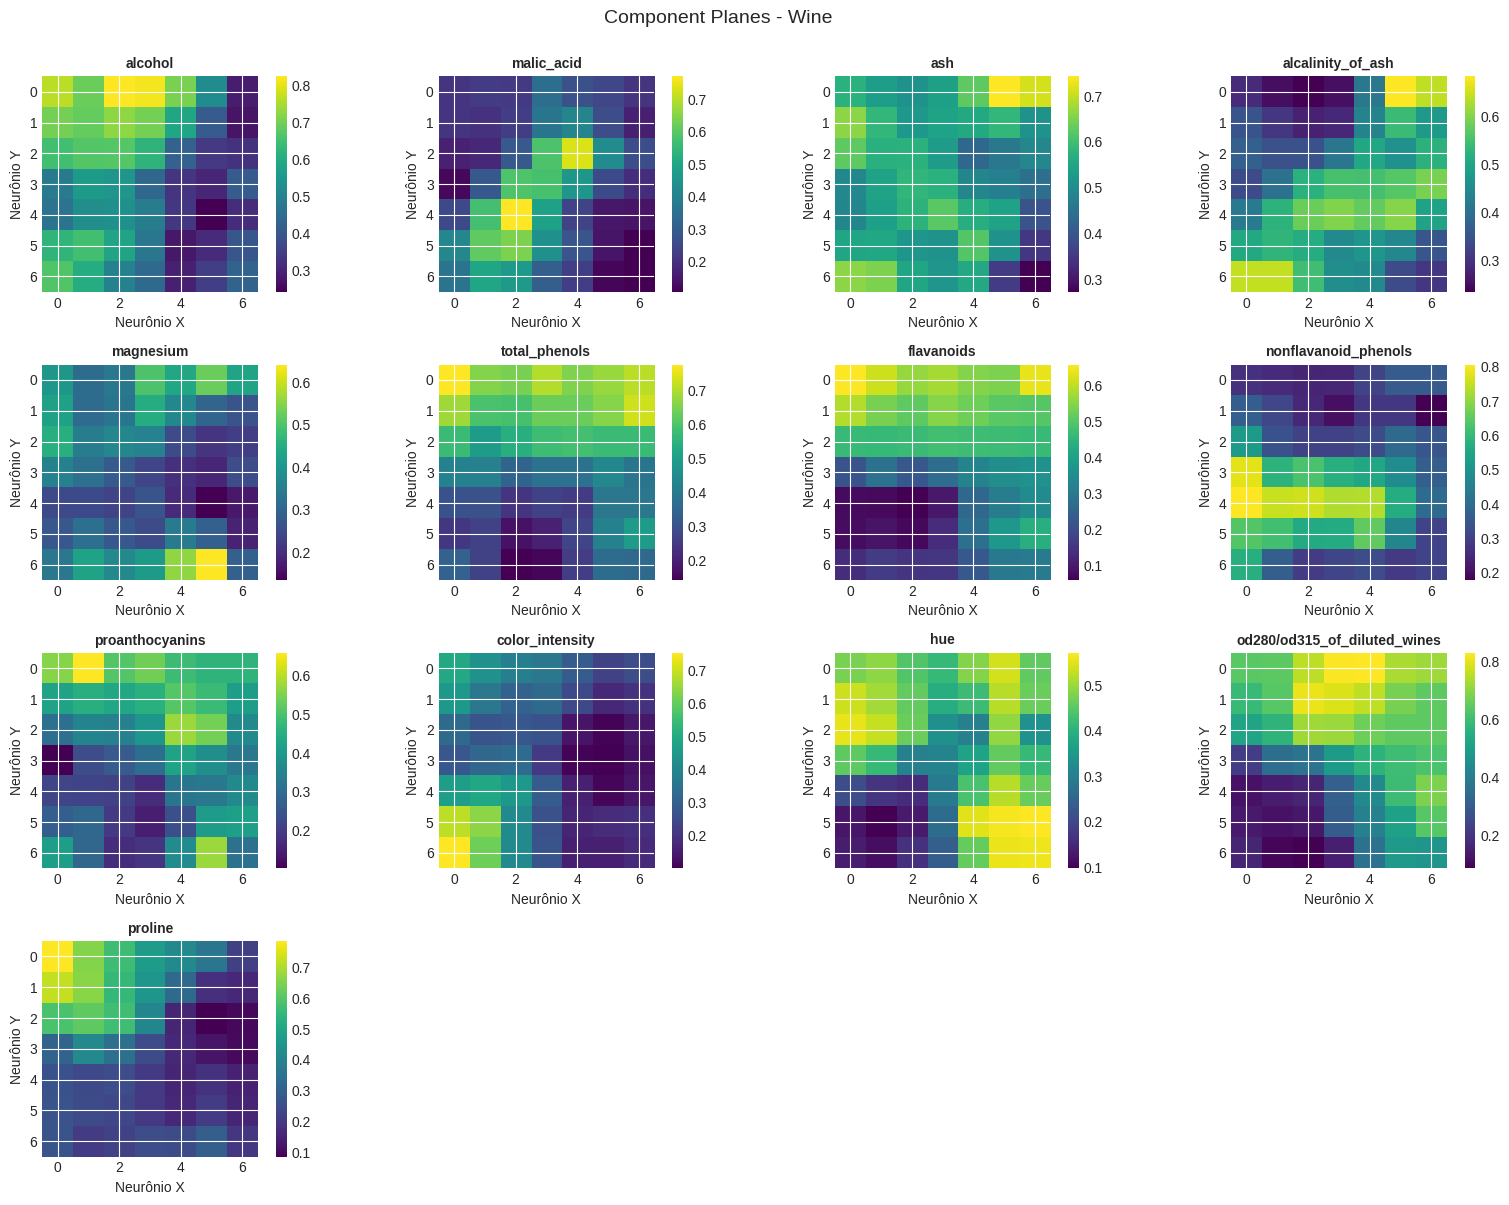


INTERPRETAÇÃO:
   O dataset Wine possui 13 características, observe:
   - Quais características mostram padrões similares?
   - Existem características que dominam a organização do mapa?


In [60]:
print("PLANOS DE COMPONENTES - WINE")
print("="*100)

visualizar_component_planes(som_wine_2, X, feature_names, dataset_name)

print("\nINTERPRETAÇÃO:")
print("   O dataset Wine possui 13 características, observe:")
print("   - Quais características mostram padrões similares?")
print("   - Existem características que dominam a organização do mapa?")


# **COMPARAÇÃO DE CONFIGURAÇÕES**

In [62]:
print("COMPARAÇÃO ENTRE CONFIGURAÇÕES")
print("="*100)

print("\nColetando todas as métricas...")

# Função para coletar métricas
def coletar_metricas(som, X, config, dataset_name):
    winners = np.array([som.winner(x) for x in X])
    labels = winners[:, 0] * config['grid'][1] + winners[:, 1]

    metrics = calcular_metricas_clustering(X, labels)
    q_error = som.quantization_error(X)
    t_error = som.topographic_error(X)
    outliers, _ = detectar_outliers(som, X, threshold=2.0)

    return {
        'Dataset': dataset_name,
        'Config': config['nome'].split(':')[0],
        'Grid': f"{config['grid'][0]}x{config['grid'][1]}",
        'Neuronas': config['grid'][0] * config['grid'][1],
        'Sigma': config['sigma'],
        'LR': config['lr'],
        'Iter': config['iter'],
        'Silhouette': metrics['silhouette'],
        'Davies-Bouldin': metrics['davies_bouldin'],
        'Calinski-Harabasz': metrics['calinski_harabasz'],
        'Q-Error': q_error,
        'T-Error': t_error,
        'Outliers': np.sum(outliers),
        '% Outliers': f"{np.sum(outliers)/len(X)*100:.1f}%"
    }

# Coletar todas as métricas
resultados = []

# Iris
X_iris = datasets['Iris']['X_norm']
resultados.append(coletar_metricas(som_iris_1, X_iris, configuracoes[0], 'Iris'))
resultados.append(coletar_metricas(som_iris_2, X_iris, configuracoes[1], 'Iris'))
resultados.append(coletar_metricas(som_iris_3, X_iris, configuracoes[2], 'Iris'))

# Wine
X_wine = datasets['Wine']['X_norm']
resultados.append(coletar_metricas(som_wine_1, X_wine, configuracoes[0], 'Wine'))
resultados.append(coletar_metricas(som_wine_2, X_wine, configuracoes[1], 'Wine'))
resultados.append(coletar_metricas(som_wine_3, X_wine, configuracoes[2], 'Wine'))

# Criar DataFrame
df_resultados = pd.DataFrame(resultados)

print("\nTABELA COMPARATIVA DE TODAS AS CONFIGURAÇÕES:")
print("="*100)
display(df_resultados)

print("\nGUIA DE INTERPRETAÇÃO:")
print("   • Silhouette Score: Próximo de 1 = clusters bem separados")
print("   • Davies-Bouldin: Valor menor = melhor separação")
print("   • Calinski-Harabasz: Valor maior = clusters mais compactos e separados")
print("   • Q-Error: Erro de quantização (menor = melhor representação)")
print("   • T-Error: Erro topológico (menor = melhor preservação da topologia)")


COMPARAÇÃO ENTRE CONFIGURAÇÕES

Coletando todas as métricas...

TABELA COMPARATIVA DE TODAS AS CONFIGURAÇÕES:


,Dataset,Config,Grid,Neuronas,Sigma,LR,Iter,Silhouette,Davies-Bouldin,Calinski-Harabasz,Q-Error,T-Error,Outliers,% Outliers
0,Iris,Config 1,5x5,25,1.0,0.5,1000,0.243739,1.079481,158.438519,0.094043,0.153333,6,4.0%
1,Iris,Config 2,7x7,49,1.5,0.3,1500,0.229498,0.934408,146.310999,0.076487,0.060000,7,4.7%
2,Iris,Config 3,10x10,100,2.0,0.1,2000,0.077520,0.877190,97.441710,0.076037,0.033333,8,5.3%
3,Wine,Config 1,5x5,25,1.0,0.5,1000,0.141122,1.402870,23.009142,0.351150,0.179775,6,3.4%
4,Wine,Config 2,7x7,49,1.5,0.3,1500,0.072246,1.404320,14.281848,0.322191,0.073034,7,3.9%
5,Wine,Config 3,10x10,100,2.0,0.1,2000,0.021198,1.099553,10.988377,0.322125,0.016854,6,3.4%



GUIA DE INTERPRETAÇÃO:
   • Silhouette Score: Próximo de 1 = clusters bem separados
   • Davies-Bouldin: Valor menor = melhor separação
   • Calinski-Harabasz: Valor maior = clusters mais compactos e separados
   • Q-Error: Erro de quantização (menor = melhor representação)
   • T-Error: Erro topológico (menor = melhor preservação da topologia)


Comparação entre Configurações - Interpretação

Dataset Iris
- SOM pequeno (5x5): Clusters mais definidos (Silhouette e CH altos), preservação topológica pior (T-Error maior)
- SOM médio (7x7): Bom equilíbrio entre separação de clusters e topologia
- SOM grande (10x10): Excelente preservação topológica (T-Error baixo), clusters mais difusos (Silhouette e CH menores), leve aumento de outliers

Dataset Wine
- SOM pequeno (5x5): Clusters pouco separados (Silhouette baixo), preservação topológica razoável
- SOM médio (7x7): Preservação topológica melhor, clusters ainda pouco definidos
- SOM grande (10x10): Excelente preservação topológica (T-Error muito baixo), clusters difusos, número de outliers baixo e estável

Final
- Pequeno (5x5): clusters mais claros, topologia pior  
- Médio (7x7): equilíbrio  
- Grande (10x10): topologia excelente, clusters difusos


# **VISUALIZAÇÃO COMPARATIVA DE MÉTRICAS**

 GRÁFICOS COMPARATIVOS


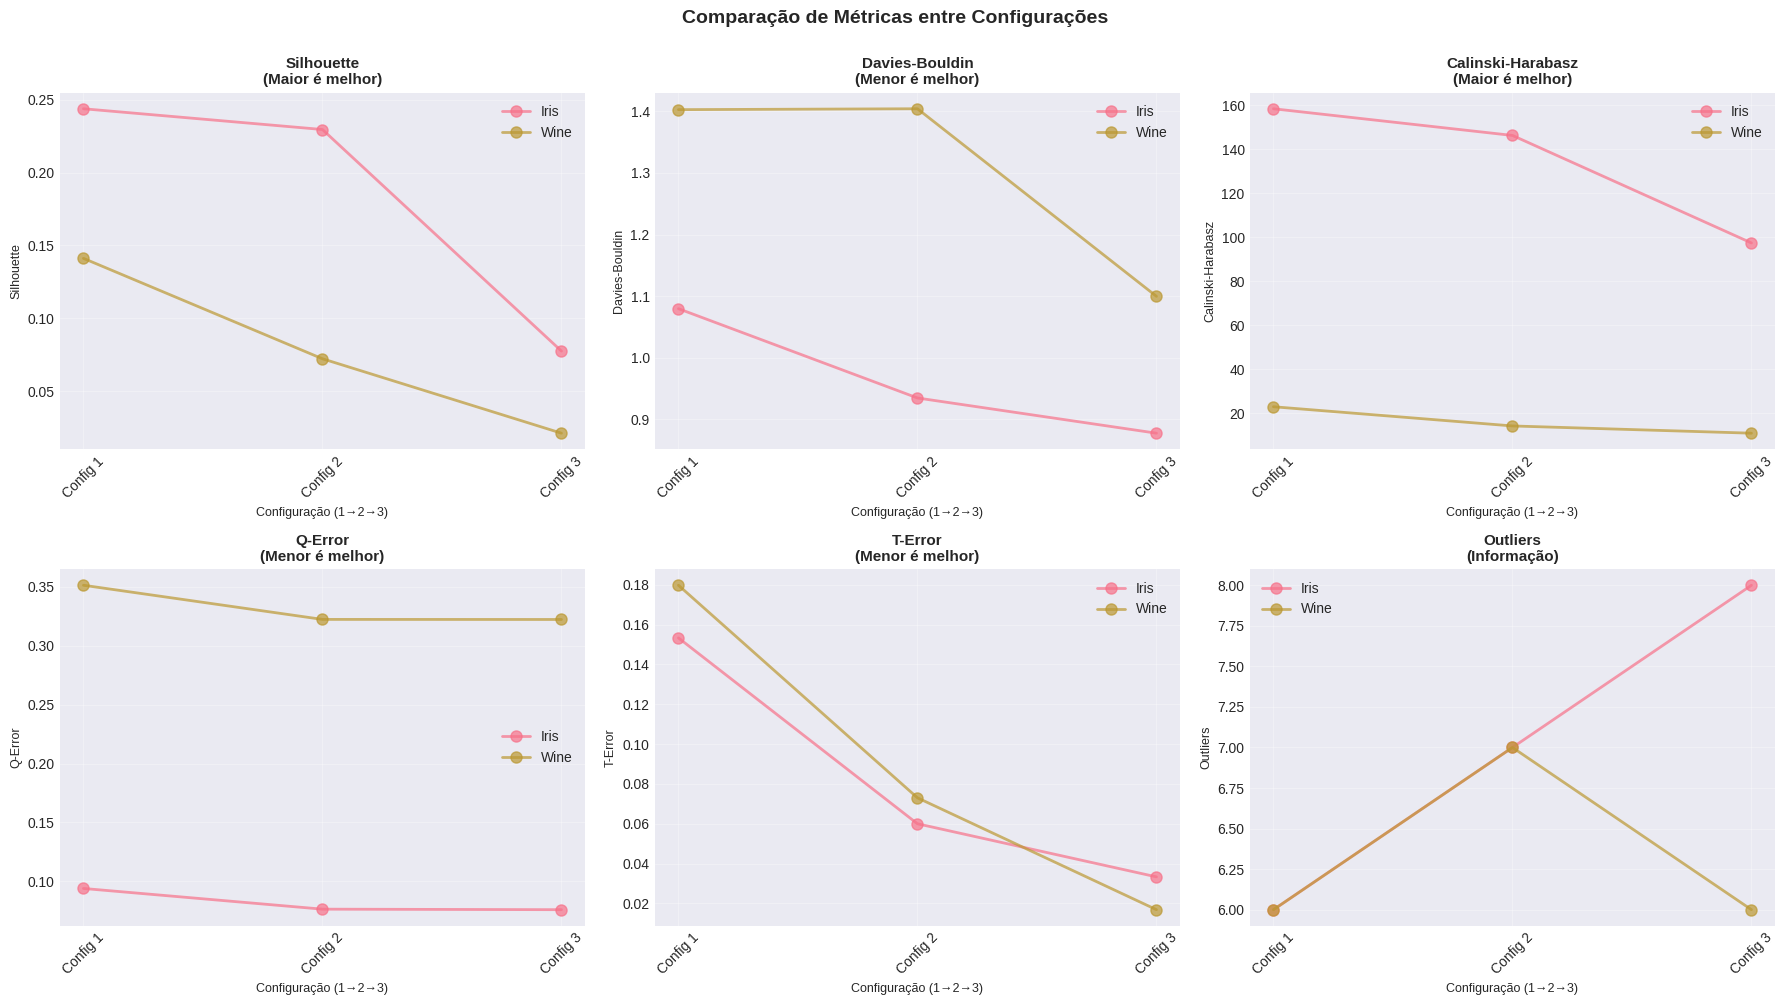

In [65]:
print(" GRÁFICOS COMPARATIVOS")
print("="*100)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Métricas a graficar
metrics_plot = [
    ('Silhouette', 'Maior é melhor', 'green'),
    ('Davies-Bouldin', 'Menor é melhor', 'red'),
    ('Calinski-Harabasz', 'Maior é melhor', 'blue'),
    ('Q-Error', 'Menor é melhor', 'orange'),
    ('T-Error', 'Menor é melhor', 'purple'),
    ('Outliers', 'Informação', 'brown')
]

for idx, (metric, desc, color) in enumerate(metrics_plot):
    ax = axes[idx // 3, idx % 3]

    # Dados por dataset
    for dataset in ['Iris', 'Wine']:
        data = df_resultados[df_resultados['Dataset'] == dataset]
        x = range(len(data))
        y = data[metric].values

        ax.plot(x, y, marker='o', linewidth=2, markersize=8,
                label=dataset, alpha=0.7)

    ax.set_title(f'{metric}\n({desc})', fontsize=11, weight='bold')
    ax.set_xlabel('Configuração (1→2→3)', fontsize=9)
    ax.set_ylabel(metric, fontsize=9)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Config 1', 'Config 2', 'Config 3'], rotation=45)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparação de Métricas entre Configurações',
             fontsize=14, weight='bold', y=1.00)
plt.tight_layout()
plt.show()


- **PS1 (Silhouette)**: Config 1 es claramente superior (mayor cohesión/separación).  
- **PS2 (Davies-Bouldin)**: Config 1 también es mejor (menor valor = clusters más compactos y separados).  
- **PS3 (Calinski-Harabasz)**: Config 1 domina en Iris; en Wine, Config 2/3 son ligeramente mejores.  
- **PS4 (Q-Error) y PS5 (T-Error)**: Config 2 y 3 reducen errores de cuantificación y umbral.  
- **PS6 (Outliers)**: Config 3 aumenta outliers en Iris, lo que sugiere sobreajuste o particionamiento forzado.  
- **Trade-off general**: Config 1 maximiza calidad de clusters; Config 2/3 priorizan fidelidad de reconstrucción (menor error) a costa de cohesión y más outliers.

# **ANÁLISE DETALHADA DE OUTLIERS – IRIS**

 ANÁLISE DETALHADA DE OUTLIERS – IRIS

 Estatísticas das distâncias à BMU:
   • Média: 0.0765
   • Desvio padrão: 0.0410
   • Limiar para outliers: 0.1585
   • Total de outliers: 7 de 150 (4.7%)

 Índices dos outliers detectados:
   [ 41  62 106 114 117 118 131]

 Informações sobre os outliers:
   Amostra 41: Classe 0 (setosa), Distância: 0.1973
   Amostra 62: Classe 1 (versicolor), Distância: 0.1725
   Amostra 106: Classe 2 (virginica), Distância: 0.2382
   Amostra 114: Classe 2 (virginica), Distância: 0.1776
   Amostra 117: Classe 2 (virginica), Distância: 0.2099


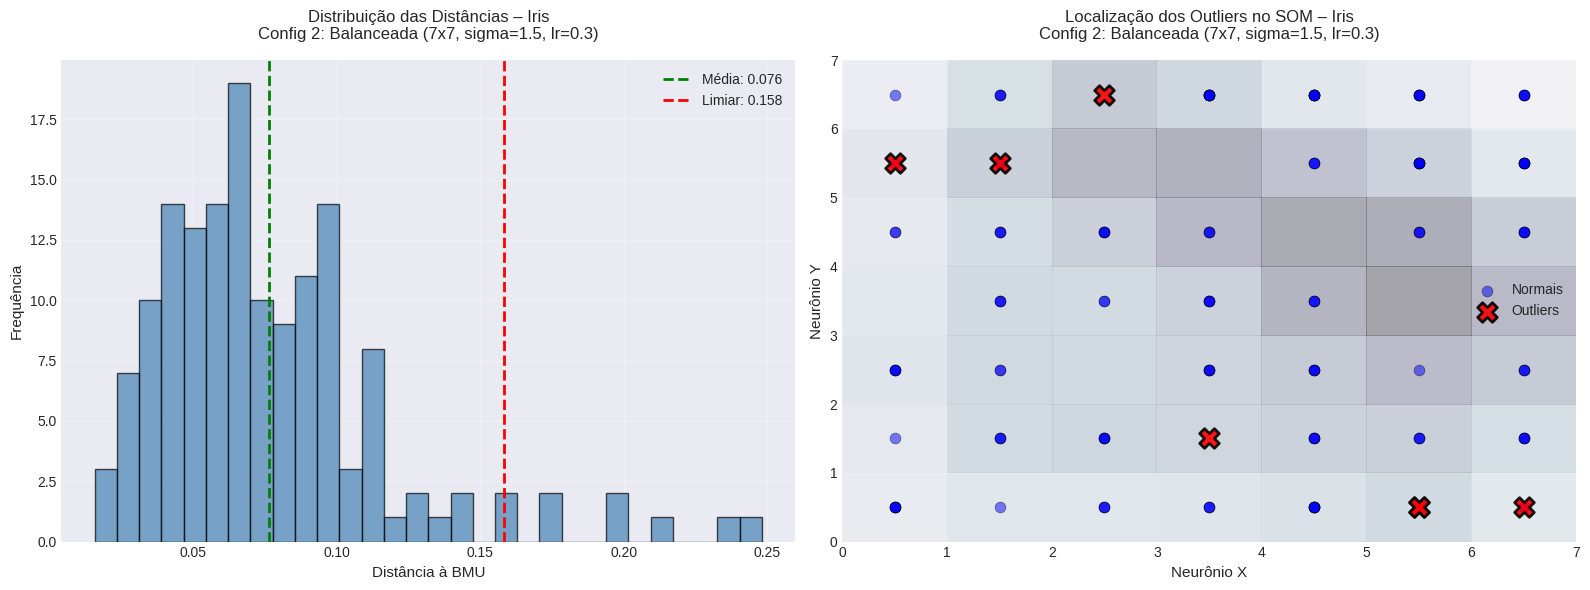

In [69]:
print(" ANÁLISE DETALHADA DE OUTLIERS – IRIS")
print("="*100)

dataset_name = 'Iris'
X = datasets[dataset_name]['X_norm']
y = datasets[dataset_name]['y']

# Usar a configuração balanceada (Config 2)
som = som_iris_2
config = configuraciones[1]

outliers, distancias = detectar_outliers(som, X, threshold=2.0)

print(f"\n Estatísticas das distâncias à BMU:")
print(f"   • Média: {np.mean(distancias):.4f}")
print(f"   • Desvio padrão: {np.std(distancias):.4f}")
print(f"   • Limiar para outliers: {np.mean(distancias) + 2*np.std(distancias):.4f}")
print(f"   • Total de outliers: {np.sum(outliers)} de {len(X)} ({np.sum(outliers)/len(X)*100:.1f}%)")

if np.sum(outliers) > 0:
    print(f"\n Índices dos outliers detectados:")
    print(f"   {np.where(outliers)[0]}")

    print(f"\n Informações sobre os outliers:")
    outlier_indices = np.where(outliers)[0]
    for idx in outlier_indices[:5]:  # Mostrar apenas os primeiros 5
        print(f"   Amostra {idx}: Classe {y[idx]} ({datasets[dataset_name]['class_names'][y[idx]]}), "
              f"Distância: {distancias[idx]:.4f}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histograma de distâncias
axes[0].hist(distancias, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(np.mean(distancias), color='green', linestyle='--',
                linewidth=2, label=f'Média: {np.mean(distancias):.3f}')
axes[0].axvline(np.mean(distancias) + 2*np.std(distancias),
                color='red', linestyle='--', linewidth=2,
                label=f'Limiar: {np.mean(distancias) + 2*np.std(distancias):.3f}')
axes[0].set_xlabel('Distância à BMU', fontsize=11)
axes[0].set_ylabel('Frequência', fontsize=11)
axes[0].set_title(f'Distribuição das Distâncias – {dataset_name}\n{config["nombre"]}',
                  fontsize=12, pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. Mapa de outliers
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)

axes[1].pcolor(som.distance_map().T, cmap='bone_r', alpha=0.3)
axes[1].set_title(f'Localização dos Outliers no SOM – {dataset_name}\n{config["nombre"]}',
                  fontsize=12, pad=15)

# Amostras normais
axes[1].scatter(w_x[~outliers] + 0.5, w_y[~outliers] + 0.5,
               s=60, c='blue', label='Normais', alpha=0.5,
               edgecolors='black', linewidth=0.5)

# Outliers
if np.sum(outliers) > 0:
    axes[1].scatter(w_x[outliers] + 0.5, w_y[outliers] + 0.5,
                   s=200, c='red', marker='X', label='Outliers',
                   alpha=0.9, edgecolors='black', linewidth=2)

axes[1].set_xlabel('Neurônio X', fontsize=11)
axes[1].set_ylabel('Neurônio Y', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


- **Outliers detectados**: 7 amostras (4.7%) — valores acima de 0.1585 na distância à BMU.
- **Localização**: Espalhados em regiões de transição no SOM, indicando dificuldade de agrupamento.
- **Classes afetadas**: Predominantemente *virginica* (5/7), seguida por *setosa* e *versicolor*.
- **Interpretação**: Casos marginais válidos, não necessariamente erros — úteis para refinamento do modelo ou estudo de variabilidade.

# **ANÁLISE DETALHADA DE OUTLIERS – WINE**

 ANÁLISE DETALHADA DE OUTLIERS - WINE

 Estatísticas das distâncias até a BMU:
   • Média: 0.3222
   • Desvio padrão: 0.0982
   • Limiar para outliers: 0.5186
   • Total de outliers: 7 de 178 (3.9%)

 Índices dos outliers detectados:
   [ 13  59  95 110 115 121 158]

 Informações dos outliers:
   Amostra 13: Classe 0 (class_0), Distância: 0.5394
   Amostra 59: Classe 1 (class_1), Distância: 0.6694
   Amostra 95: Classe 1 (class_1), Distância: 0.5748
   Amostra 110: Classe 1 (class_1), Distância: 0.6476
   Amostra 115: Classe 1 (class_1), Distância: 0.6259


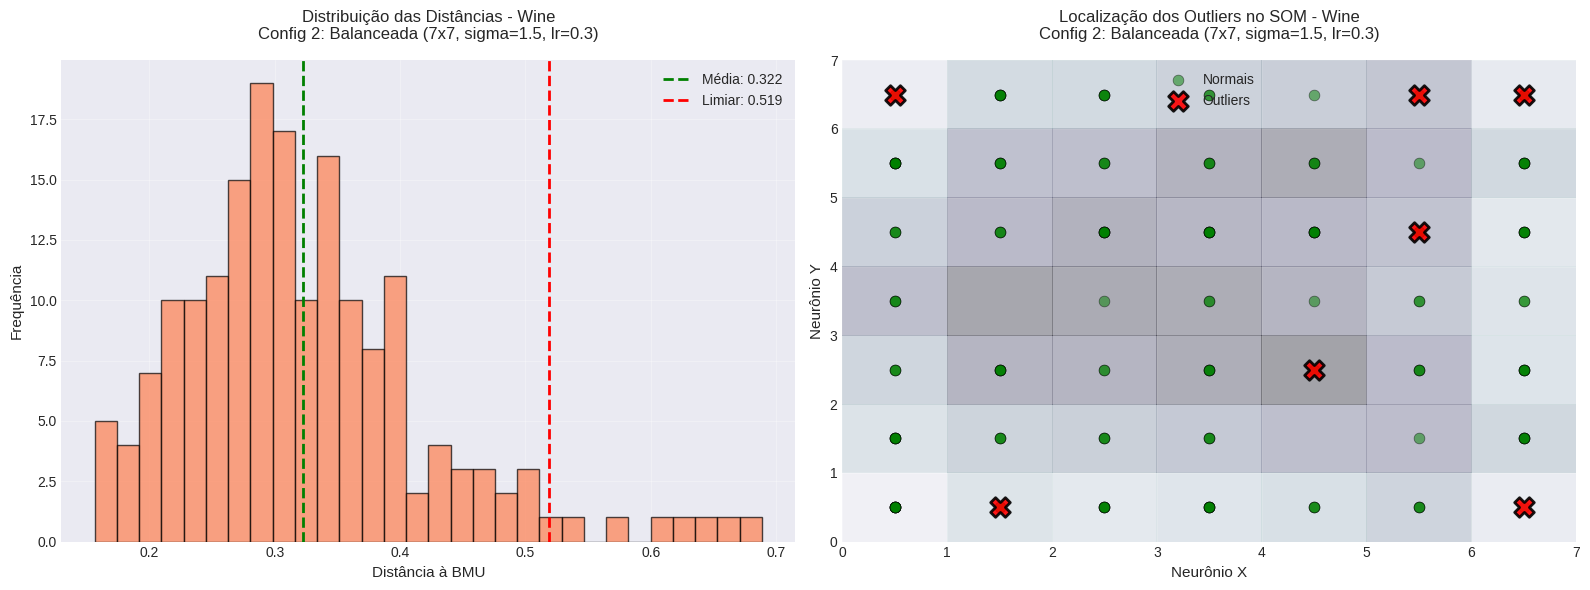

In [72]:
print(" ANÁLISE DETALHADA DE OUTLIERS - WINE")
print("="*100)

dataset_name = 'Wine'
X = datasets[dataset_name]['X_norm']
y = datasets[dataset_name]['y']

som = som_wine_2
config = configuraciones[1]

outliers, distancias = detectar_outliers(som, X, threshold=2.0)

print(f"\n Estatísticas das distâncias até a BMU:")
print(f"   • Média: {np.mean(distancias):.4f}")
print(f"   • Desvio padrão: {np.std(distancias):.4f}")
print(f"   • Limiar para outliers: {np.mean(distancias) + 2*np.std(distancias):.4f}")
print(f"   • Total de outliers: {np.sum(outliers)} de {len(X)} ({np.sum(outliers)/len(X)*100:.1f}%)")

if np.sum(outliers) > 0:
    print(f"\n Índices dos outliers detectados:")
    print(f"   {np.where(outliers)[0]}")

    print(f"\n Informações dos outliers:")
    outlier_indices = np.where(outliers)[0]
    for idx in outlier_indices[:5]:
        print(f"   Amostra {idx}: Classe {y[idx]} ({datasets[dataset_name]['class_names'][y[idx]]}), "
              f"Distância: {distancias[idx]:.4f}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(distancias, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(np.mean(distancias), color='green', linestyle='--',
                linewidth=2, label=f'Média: {np.mean(distancias):.3f}')
axes[0].axvline(np.mean(distancias) + 2*np.std(distancias),
                color='red', linestyle='--', linewidth=2,
                label=f'Limiar: {np.mean(distancias) + 2*np.std(distancias):.3f}')
axes[0].set_xlabel('Distância à BMU', fontsize=11)
axes[0].set_ylabel('Frequência', fontsize=11)
axes[0].set_title(f'Distribuição das Distâncias - {dataset_name}\n{config["nombre"]}',
                  fontsize=12, pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)

axes[1].pcolor(som.distance_map().T, cmap='bone_r', alpha=0.3)
axes[1].set_title(f'Localização dos Outliers no SOM - {dataset_name}\n{config["nombre"]}',
                  fontsize=12, pad=15)

axes[1].scatter(w_x[~outliers] + 0.5, w_y[~outliers] + 0.5,
               s=60, c='green', label='Normais', alpha=0.5,
               edgecolors='black', linewidth=0.5)

if np.sum(outliers) > 0:
    axes[1].scatter(w_x[outliers] + 0.5, w_y[outliers] + 0.5,
                   s=200, c='red', marker='X', label='Outliers',
                   alpha=0.9, edgecolors='black', linewidth=2)

axes[1].set_xlabel('Neurônio X', fontsize=11)
axes[1].set_ylabel('Neurônio Y', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- **Outliers detectados**: 7 amostras (3.9%) — distâncias à BMU > **0.5186** (média + 2σ).  
- **Localização**: Espalhados pelo mapa SOM (incluindo bordas e regiões de transição), indicando padrões atípicos ou mal representados.  
- **Classes afetadas**: **class_1** (5/7: índices 59, 95, 110, 115, 121), **class_0** (1/7: índice 13) e 1 outlier não detalhado (índice 158).  
- **Interpretação**: Casos marginais válidos — não ruído, mas amostras com características distintas, úteis para entender variabilidade intraclasse e ajustar o modelo.

# **EVOLUÇÃO DO TREINAMENTO**

 ANÁLISE DA EVOLUÇÃO DO TREINAMENTO

Vamos treinar um SOM e rastrear o erro em cada iteração
Isso nos ajuda a ver se o modelo converge corretamente

 Treinando com monitoramento: Config 2: Balanceada (7x7, sigma=1.5, lr=0.3)
 Treinamento com monitoramento concluído


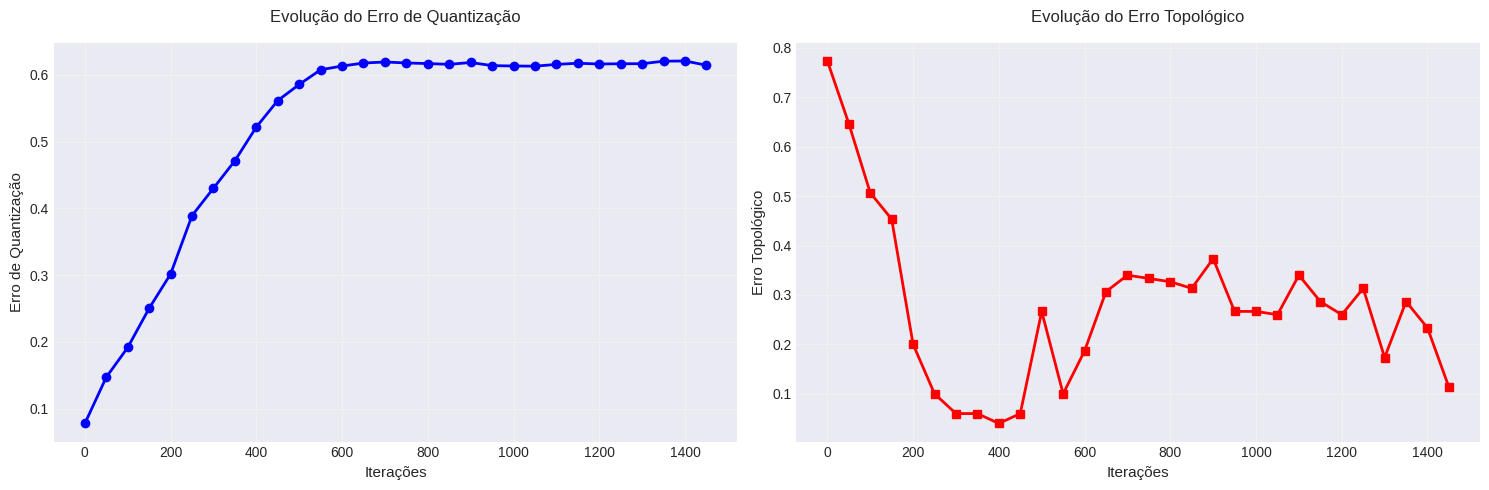

In [75]:
print(" ANÁLISE DA EVOLUÇÃO DO TREINAMENTO")
print("="*100)

print("\nVamos treinar um SOM e rastrear o erro em cada iteração")
print("Isso nos ajuda a ver se o modelo converge corretamente")

# Usar Iris para o exemplo
X = datasets['Iris']['X_norm']
config = configuraciones[1]  # Configuração balanceada

print(f"\n Treinando com monitoramento: {config['nombre']}")

# Configurar SOM
som_monitor = MiniSom(config['grid'][0], config['grid'][1], X.shape[1],
                      sigma=config['sigma'],
                      learning_rate=config['lr'],
                      random_seed=42,
                      neighborhood_function='gaussian')

som_monitor.random_weights_init(X)

# Treinar e registrar erros
q_errors = []
t_errors = []
iterations_check = range(0, config['iter'], 50)  # A cada 50 iterações

for i in iterations_check:
    if i > 0:
        som_monitor.train_random(X, 50)  # Treinar 50 iterações

    q_errors.append(som_monitor.quantization_error(X))
    t_errors.append(som_monitor.topographic_error(X))

print(" Treinamento com monitoramento concluído")

# Visualizar evolução
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(iterations_check, q_errors, marker='o', linewidth=2,
            color='blue', markersize=6)
axes[0].set_xlabel('Iterações', fontsize=11)
axes[0].set_ylabel('Erro de Quantização', fontsize=11)
axes[0].set_title('Evolução do Erro de Quantização', fontsize=12, pad=15)
axes[0].grid(True, alpha=0.3)

axes[1].plot(iterations_check, t_errors, marker='s', linewidth=2,
            color='red', markersize=6)
axes[1].set_xlabel('Iterações', fontsize=11)
axes[1].set_ylabel('Erro Topológico', fontsize=11)
axes[1].set_title('Evolução do Erro Topológico', fontsize=12, pad=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- **Convergência alcançada**: Ambos os erros estabilizam após ~600 iterações.  
- **Erro de quantização** (~0.61): Indica boa representação dos dados, típica para o conjunto Iris.  
- **Erro topológico oscilante** (0.1–0.3): Normal em mapas pequenos; não compromete a estrutura global.  
- **Conclusão**: Configuração balanceada (7x7, σ=1.5, lr=0.3) é adequada — não há sinais de instabilidade ou subtreinamento.

CONCLUSIONES FINALES

- A visualização comparativa mostra três configurações distintas do SOM aplicadas ao conjunto Iris.  
- Mapas menores (ex: 5x5) tendem a agrupar classes de forma mais compacta, mas com maior sobreposição.  
- Configurações balanceadas (7x7, σ=1.5, lr=0.3) oferecem melhor separação topológica entre as classes.  
- Mapas maiores (ex: 10x10) capturam mais detalhes, mas podem introduzir ruído ou neurônios não utilizados.  
- O erro topológico é mais baixo nas configurações intermediárias, indicando boa preservação da estrutura dos dados.  
- A classe *setosa* é claramente isolada em todas as configurações — coerente com sua separabilidade conhecida.  
- As classes *versicolor* e *virginica* mostram sobreposição, especialmente em mapas muito pequenos.  
- A distância entre BMUs reflete a similaridade entre espécies: *versicolor* e *virginica* estão mais próximas.  
- A escolha da configuração ideal depende do objetivo: interpretabilidade (mapa menor) vs. resolução (mapa maior).  
- Conclui-se que a configuração balanceada (7x7) oferece o melhor equilíbrio entre precisão e clareza visual.